## Name: N S Ramanujam Mangena
## Walsh DBA Capstone Final Report
## Topic: Strategic Wildfire Management: Leveraging Data Analysis and Machine Learning

# Data Loading and Initial Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load data from the specified Excel file and its tabs
excel_file_path = '/content/drive/MyDrive/capstone/2007-2024-IMSR-1.09.xlsx'

try:
    national_activity_df = pd.read_excel(excel_file_path, sheet_name='national_activity')
    gacc_activity_df = pd.read_excel(excel_file_path, sheet_name='gacc_activity')
    wildfire_activity_df = pd.read_excel(excel_file_path, sheet_name='wildfire_activity')
    resource_summary_df = pd.read_excel(excel_file_path, sheet_name='resource_summary')

    print("✓ Successfully loaded all data sheets")
    print(f"National Activity: {national_activity_df.shape}")
    print(f"GACC Activity: {gacc_activity_df.shape}")
    print(f"Wildfire Activity: {wildfire_activity_df.shape}")
    print(f"Resource Summary: {resource_summary_df.shape}")

except Exception as e:
    print(f"Error loading data: {e}")

✓ Successfully loaded all data sheets
National Activity: (3709, 13)
GACC Activity: (20072, 13)
Wildfire Activity: (115411, 20)
Resource Summary: (19380, 9)


# Data Exploration and Quality Assessment


## 1.1 Dataset Overview

In [7]:
# Examine structure of each dataset
datasets = {
    'National Activity': national_activity_df,
    'GACC Activity': gacc_activity_df,
    'Wildfire Activity': wildfire_activity_df,
    'Resource Summary': resource_summary_df
}

for name, df in datasets.items():
    print(f"\n=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head(2))
    print("\nData types:")
    print(df.dtypes)


=== National Activity Dataset ===
Shape: (3709, 13)
Columns: ['imsr_date', 'preparedness_level', 'initial_attack_activity', 'new_fires', 'new_large_fires', 'contained_large_fires', 'uncontained_large_fires', 'area_command_teams', 'nimos', 'type_1_teams', 'type_2_teams', 'fire_use_teams', 'complex_teams']

First few rows:
    imsr_date  preparedness_level initial_attack_activity  new_fires  \
0  2007-01-05                   1                   LIGHT       34.0   
1  2007-01-12                   1                   LIGHT       99.0   

   new_large_fires  contained_large_fires  uncontained_large_fires  \
0              0.0                    0.0                        0   
1              3.0                    1.0                        2   

   area_command_teams  nimos  type_1_teams  type_2_teams  fire_use_teams  \
0                 NaN    NaN           NaN           1.0             NaN   
1                 NaN    NaN           NaN           NaN             NaN   

   complex_teams  


## 1.2 Missing Data Analysis


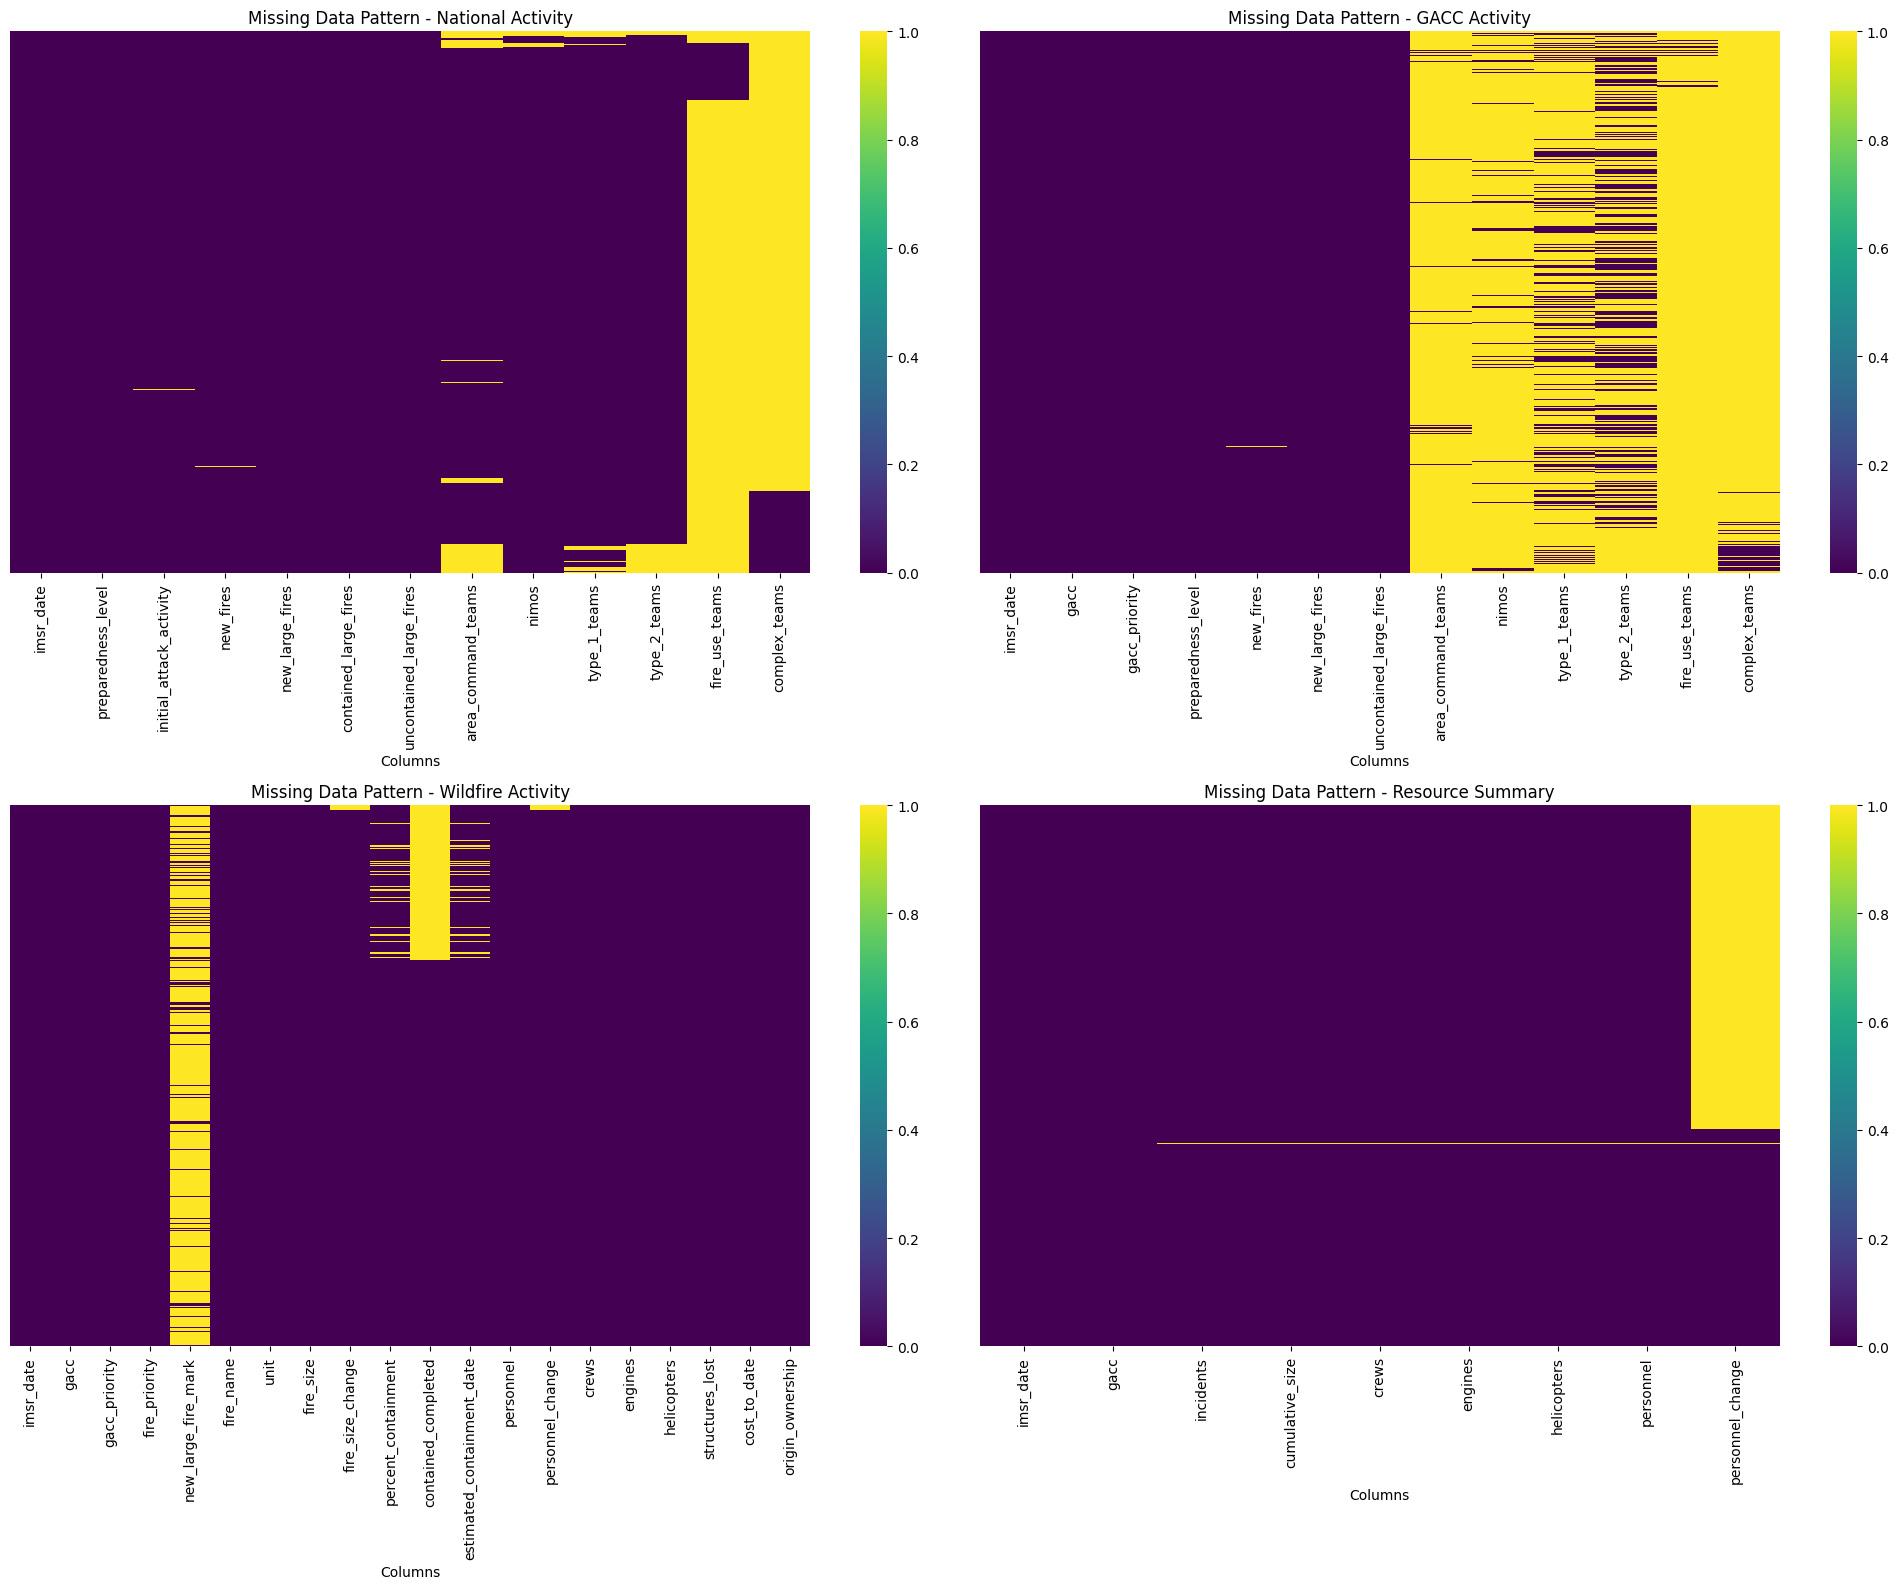


=== Missing Data Summary: National Activity ===
                                          Column  Missing_Count  \
fire_use_teams                    fire_use_teams           3322   
complex_teams                      complex_teams           3151   
area_command_teams            area_command_teams            344   
type_2_teams                        type_2_teams            219   
type_1_teams                        type_1_teams            111   
nimos                                      nimos             61   
initial_attack_activity  initial_attack_activity              6   
new_fires                              new_fires              2   
new_large_fires                  new_large_fires              1   
contained_large_fires      contained_large_fires              1   

                         Missing_Percentage  
fire_use_teams                    89.565921  
complex_teams                     84.955514  
area_command_teams                 9.274737  
type_2_teams                 

In [8]:
# Create comprehensive missing data visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, (name, df) in enumerate(datasets.items()):
    # Missing data heatmap
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis', ax=axes[i])
    axes[i].set_title(f'Missing Data Pattern - {name}')
    axes[i].set_xlabel('Columns')

plt.tight_layout()
plt.show()

# Missing data summary for each dataset
for name, df in datasets.items():
    missing_summary = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    }).sort_values('Missing_Percentage', ascending=False)

    print(f"\n=== Missing Data Summary: {name} ===")
    print(missing_summary[missing_summary['Missing_Count'] > 0])

## 1.3 Data Preprocessing and Feature Engineering

In [9]:
# Merge datasets based on common keys (adjust based on actual column names)
# This will need to be customized based on your actual data structure

# Example merge - adjust column names as needed
if 'imsr_date' in national_activity_df.columns and 'imsr_date' in wildfire_activity_df.columns:
    main_df = pd.merge(national_activity_df, wildfire_activity_df, on='imsr_date', how='outer')
elif 'imsr_date' in national_activity_df.columns:
    main_df = national_activity_df.copy()
else:
    # Use the largest dataset as main
    main_df = max(datasets.values(), key=len).copy()

print(f"Main dataset shape after merging: {main_df.shape}")

# Create derived variables based on available columns
# Note: Column names will need to be adjusted based on actual data structure

# Common preparedness/cost analysis variables
if 'prep_level' in main_df.columns or 'preparedness_level' in main_df.columns:
    prep_col = 'prep_level' if 'prep_level' in main_df.columns else 'preparedness_level'
    main_df['preparedness_level'] = main_df[prep_col]

# Fire size and cost variables
size_cols = [col for col in main_df.columns if 'size' in col.lower() or 'acre' in col.lower()]
cost_cols = [col for col in main_df.columns if 'cost' in col.lower() or 'dollar' in col.lower()]

if size_cols:
    main_df['fire_size_acres'] = main_df[size_cols[0]]
if cost_cols:
    main_df['suppression_cost'] = main_df[cost_cols[0]]

# Convert 'fire_size_acres' and 'suppression_cost' to numeric, handling different formats
def convert_size_cost_to_numeric(df, column):
    """Converts size and cost columns to numeric, handling 'M', 'K', and 'NR' values."""
    df[column] = df[column].astype(str).str.upper().str.replace('M', 'e6').str.replace('K', 'e3')
    df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

if 'fire_size_acres' in main_df.columns:
    main_df = convert_size_cost_to_numeric(main_df, 'fire_size_acres')

if 'suppression_cost' in main_df.columns:
    main_df = convert_size_cost_to_numeric(main_df, 'suppression_cost')


# Year extraction
year_cols = [col for col in main_df.columns if 'year' in col.lower() or 'date' in col.lower()]
if year_cols:
    if pd.api.types.is_datetime64_any_dtype(main_df[year_cols[0]]):
        main_df['fire_year'] = main_df[year_cols[0]].dt.year
    else:
         try:
            main_df['fire_year'] = pd.to_datetime(main_df[year_cols[0]]).dt.year
         except Exception as e:
            print(f"Could not extract year: {e}")
            main_df['fire_year'] = None


# Create additional derived variables
if 'fire_size_acres' in main_df.columns and 'suppression_cost' in main_df.columns:
    # Avoid division by zero and handle potential NaN values after conversion
    main_df['cost_per_acre'] = main_df.apply(
        lambda row: row['suppression_cost'] / row['fire_size_acres'] if pd.notnull(row['suppression_cost']) and row['fire_size_acres'] > 0 and pd.notnull(row['fire_size_acres']) else np.nan,
        axis=1
    )
    main_df['high_cost_event'] = (main_df['suppression_cost'] > 1000000).astype(int)

# Decade grouping
if 'fire_year' in main_df.columns and main_df['fire_year'].dtype == 'int64':
    main_df['decade'] = (main_df['fire_year'] // 10) * 10

print("Available columns in main dataset:")
print(list(main_df.columns))

Main dataset shape after merging: (115443, 32)
Available columns in main dataset:
['imsr_date', 'preparedness_level', 'initial_attack_activity', 'new_fires', 'new_large_fires', 'contained_large_fires', 'uncontained_large_fires', 'area_command_teams', 'nimos', 'type_1_teams', 'type_2_teams', 'fire_use_teams', 'complex_teams', 'gacc', 'gacc_priority', 'fire_priority', 'new_large_fire_mark', 'fire_name', 'unit', 'fire_size', 'fire_size_change', 'percent_containment', 'contained_completed', 'estimated_containment_date', 'personnel', 'personnel_change', 'crews', 'engines', 'helicopters', 'structures_lost', 'cost_to_date', 'origin_ownership', 'fire_size_acres', 'suppression_cost', 'fire_year', 'cost_per_acre', 'high_cost_event']


# RQ1: Preparedness Levels and Fire Containment Over Time


##2.1 Preparedness Analysis Setup

In [10]:
# Identify relevant columns for preparedness analysis
containment_cols = [col for col in main_df.columns if 'contain' in col.lower() or 'control' in col.lower()]
prep_cols = [col for col in main_df.columns if 'prep' in col.lower() or 'level' in col.lower()]

print("Containment-related columns:", containment_cols)
print("Preparedness-related columns:", prep_cols)

# Use available columns for analysis
if containment_cols:
    main_df['containment_pct'] = main_df[containment_cols[0]]
if prep_cols:
    main_df['preparedness_level'] = main_df[prep_cols[0]]

Containment-related columns: ['contained_large_fires', 'uncontained_large_fires', 'percent_containment', 'contained_completed', 'estimated_containment_date']
Preparedness-related columns: ['preparedness_level']


## 2.2 Temporal Trends Visualization

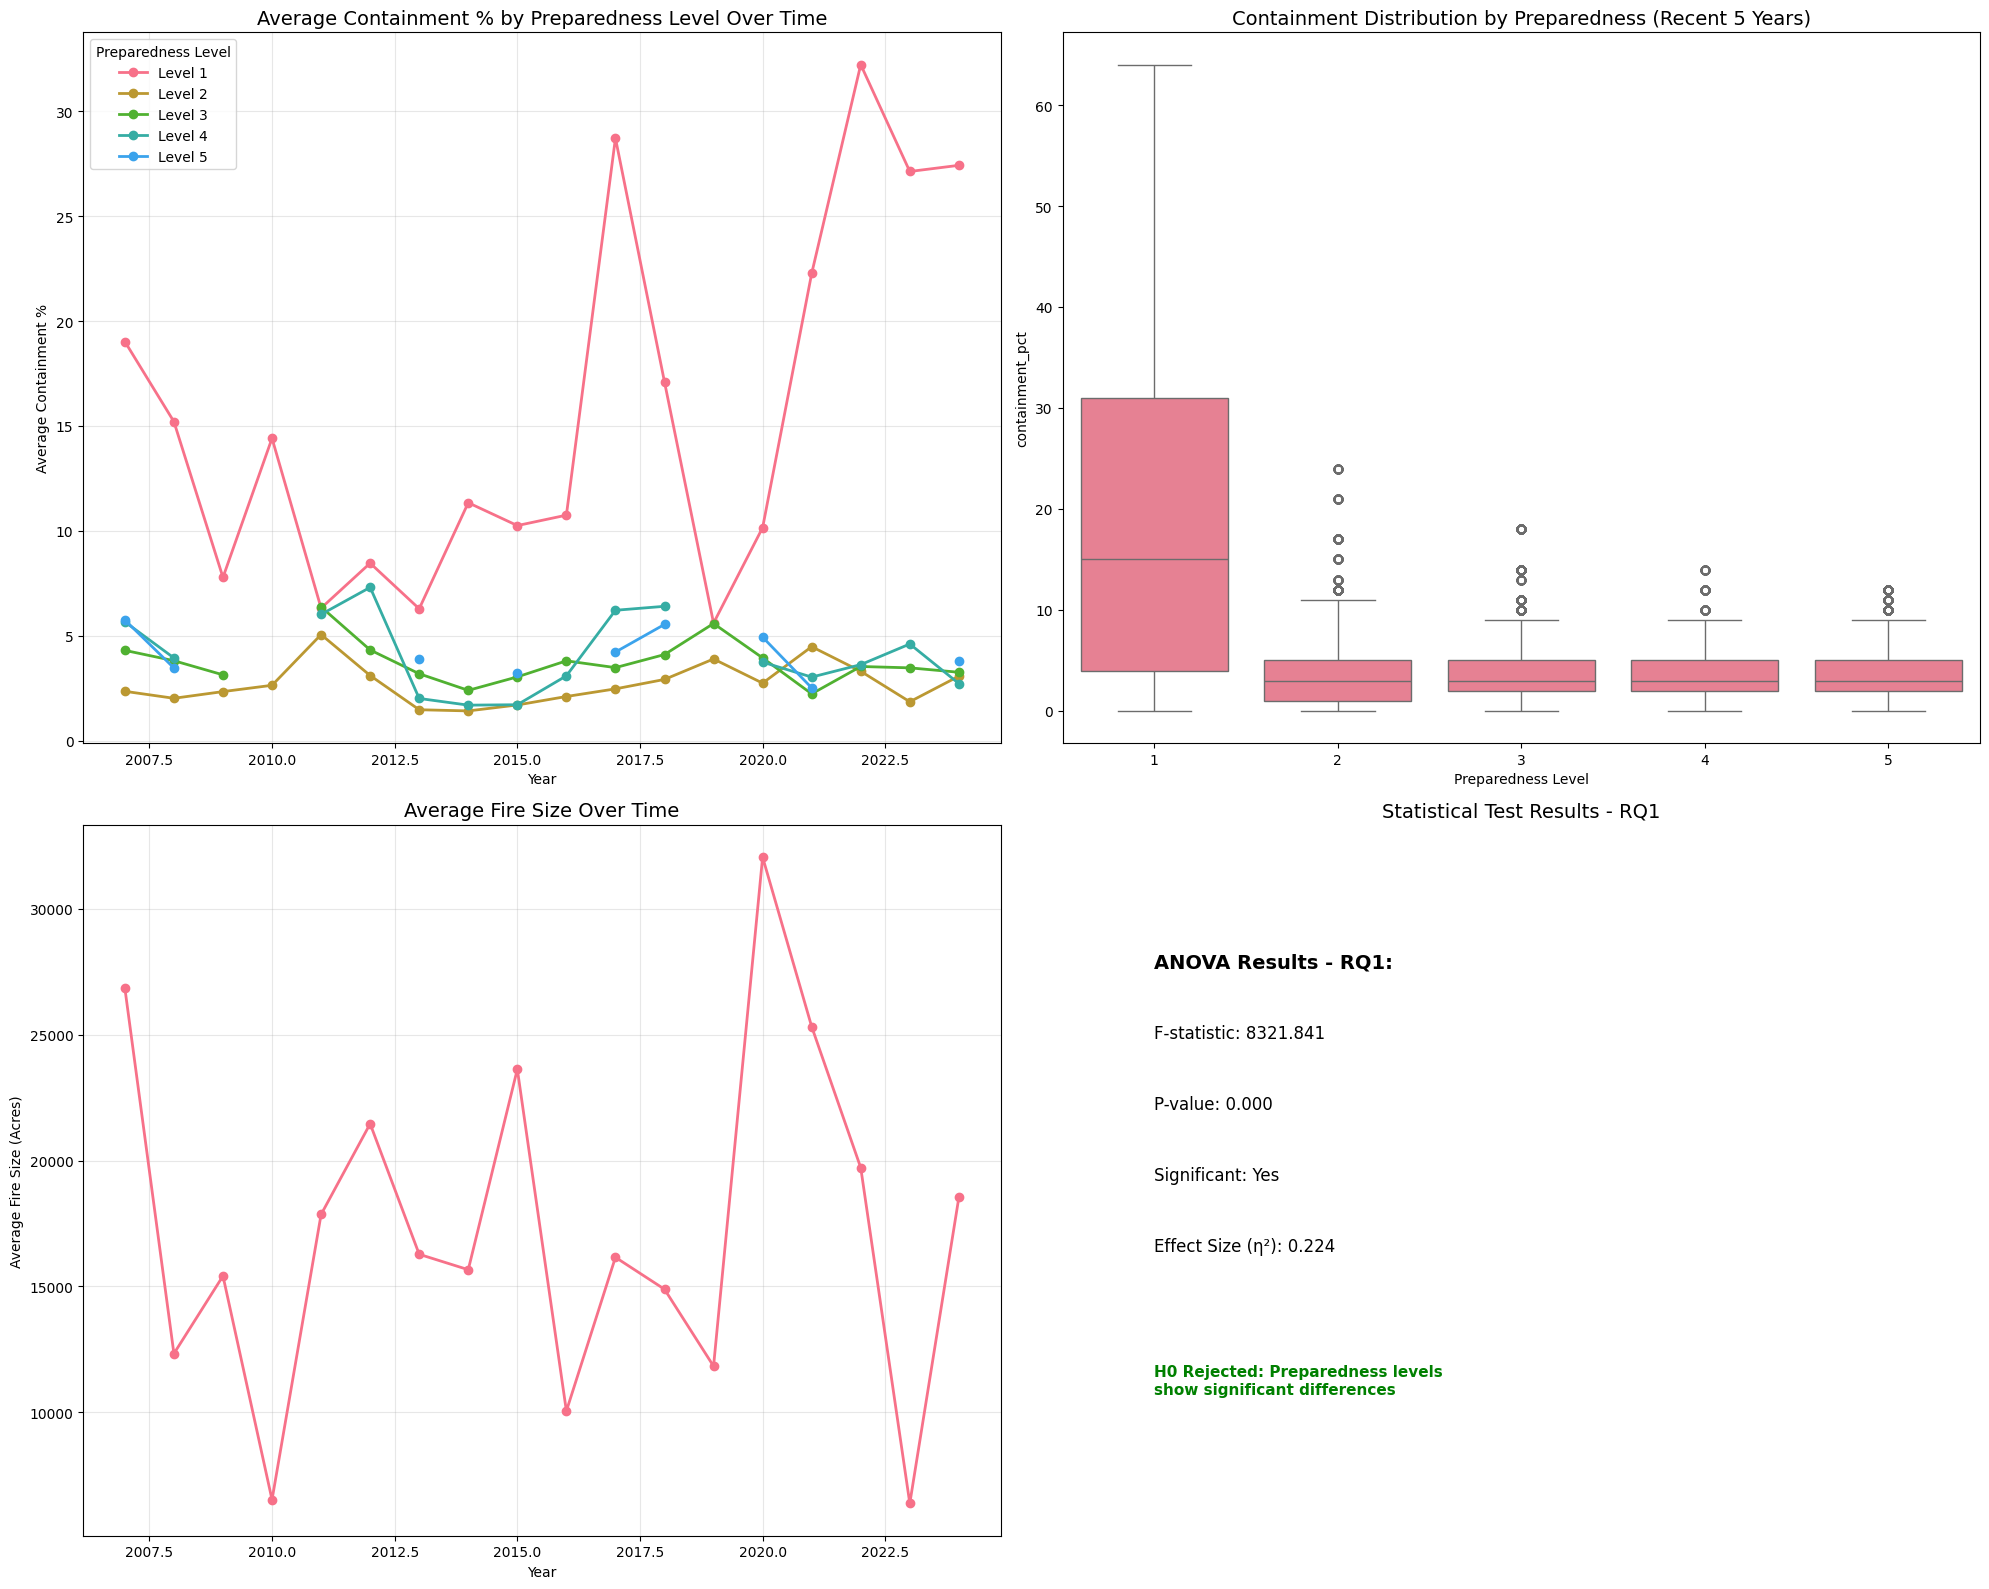

In [11]:
# Figure 1: Preparedness and Containment Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Check if required columns exist
if 'preparedness_level' in main_df.columns and 'fire_year' in main_df.columns:

    # Subplot 1: Preparedness levels over time
    if 'containment_pct' in main_df.columns:
        yearly_prep = main_df.groupby(['fire_year', 'preparedness_level'])['containment_pct'].mean().reset_index()
        prep_pivot = yearly_prep.pivot(index='fire_year', columns='preparedness_level', values='containment_pct')

        for col in prep_pivot.columns:
            axes[0,0].plot(prep_pivot.index, prep_pivot[col], marker='o', linewidth=2, label=f'Level {col}')

        axes[0,0].set_title('Average Containment % by Preparedness Level Over Time', fontsize=14)
        axes[0,0].set_xlabel('Year')
        axes[0,0].set_ylabel('Average Containment %')
        axes[0,0].legend(title='Preparedness Level')
        axes[0,0].grid(True, alpha=0.3)
    else:
        axes[0,0].text(0.5, 0.5, 'Containment data not available', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Containment Analysis - Data Not Available')

    # Subplot 2: Distribution analysis for recent years
    recent_years = main_df['fire_year'].max() - 5
    recent_data = main_df[main_df['fire_year'] >= recent_years]

    if 'containment_pct' in main_df.columns:
        sns.boxplot(data=recent_data, x='preparedness_level', y='containment_pct', ax=axes[0,1])
        axes[0,1].set_title('Containment Distribution by Preparedness (Recent 5 Years)', fontsize=14)
    else:
        prep_counts = recent_data['preparedness_level'].value_counts().sort_index()
        axes[0,1].bar(prep_counts.index, prep_counts.values)
        axes[0,1].set_title('Preparedness Level Distribution (Recent 5 Years)', fontsize=14)

    axes[0,1].set_xlabel('Preparedness Level')

else:
    axes[0,0].text(0.5, 0.5, 'Preparedness level data not available', ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,1].text(0.5, 0.5, 'Preparedness level data not available', ha='center', va='center', transform=axes[0,1].transAxes)

# Subplot 3: Temporal trends in fire activity
if 'fire_year' in main_df.columns:
    yearly_summary = main_df.groupby('fire_year').agg({
        col: 'mean' for col in main_df.columns if main_df[col].dtype in ['int64', 'float64']
    }).reset_index()

    # Plot fire size trends if available
    if 'fire_size_acres' in main_df.columns:
        axes[1,0].plot(yearly_summary['fire_year'], yearly_summary['fire_size_acres'], marker='o', linewidth=2)
        axes[1,0].set_title('Average Fire Size Over Time', fontsize=14)
        axes[1,0].set_ylabel('Average Fire Size (Acres)')
    else:
        axes[1,0].plot(yearly_summary['fire_year'], yearly_summary.iloc[:, 1], marker='o', linewidth=2)
        axes[1,0].set_title('Fire Activity Trend Over Time', fontsize=14)

    axes[1,0].set_xlabel('Year')
    axes[1,0].grid(True, alpha=0.3)

# Subplot 4: Statistical analysis results
if 'preparedness_level' in main_df.columns and 'containment_pct' in main_df.columns:
    prep_groups = [main_df[main_df['preparedness_level'] == level]['containment_pct'].dropna()
                   for level in sorted(main_df['preparedness_level'].unique())]
    prep_groups = [group for group in prep_groups if len(group) > 0]

    if len(prep_groups) > 1:
        f_stat, p_value = stats.f_oneway(*prep_groups)
        axes[1,1].text(0.1, 0.8, f'ANOVA Results - RQ1:', transform=axes[1,1].transAxes, fontsize=14, weight='bold')
        axes[1,1].text(0.1, 0.7, f'F-statistic: {f_stat:.3f}', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].text(0.1, 0.6, f'P-value: {p_value:.3f}', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].text(0.1, 0.5, f'Significant: {"Yes" if p_value < 0.05 else "No"}', transform=axes[1,1].transAxes, fontsize=12)

        # Effect size (eta squared)
        ss_between = sum(len(group) * (group.mean() - main_df['containment_pct'].mean())**2 for group in prep_groups)
        ss_total = sum((main_df['containment_pct'].dropna() - main_df['containment_pct'].mean())**2)
        eta_squared = ss_between / ss_total
        axes[1,1].text(0.1, 0.4, f'Effect Size (η²): {eta_squared:.3f}', transform=axes[1,1].transAxes, fontsize=12)

        if p_value < 0.05:
            axes[1,1].text(0.1, 0.2, 'H0 Rejected: Preparedness levels\nshow significant differences',
                          transform=axes[1,1].transAxes, fontsize=11, color='green', weight='bold')
        else:
            axes[1,1].text(0.1, 0.2, 'H0 Not Rejected: No significant\ndifference found',
                          transform=axes[1,1].transAxes, fontsize=11, color='red', weight='bold')
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient data for statistical test', ha='center', va='center', transform=axes[1,1].transAxes)

axes[1,1].set_title('Statistical Test Results - RQ1', fontsize=14)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# RQ2: Nonlinear Cost Escalation Analysis

## 3.1 Cost-Size Relationship Analysis

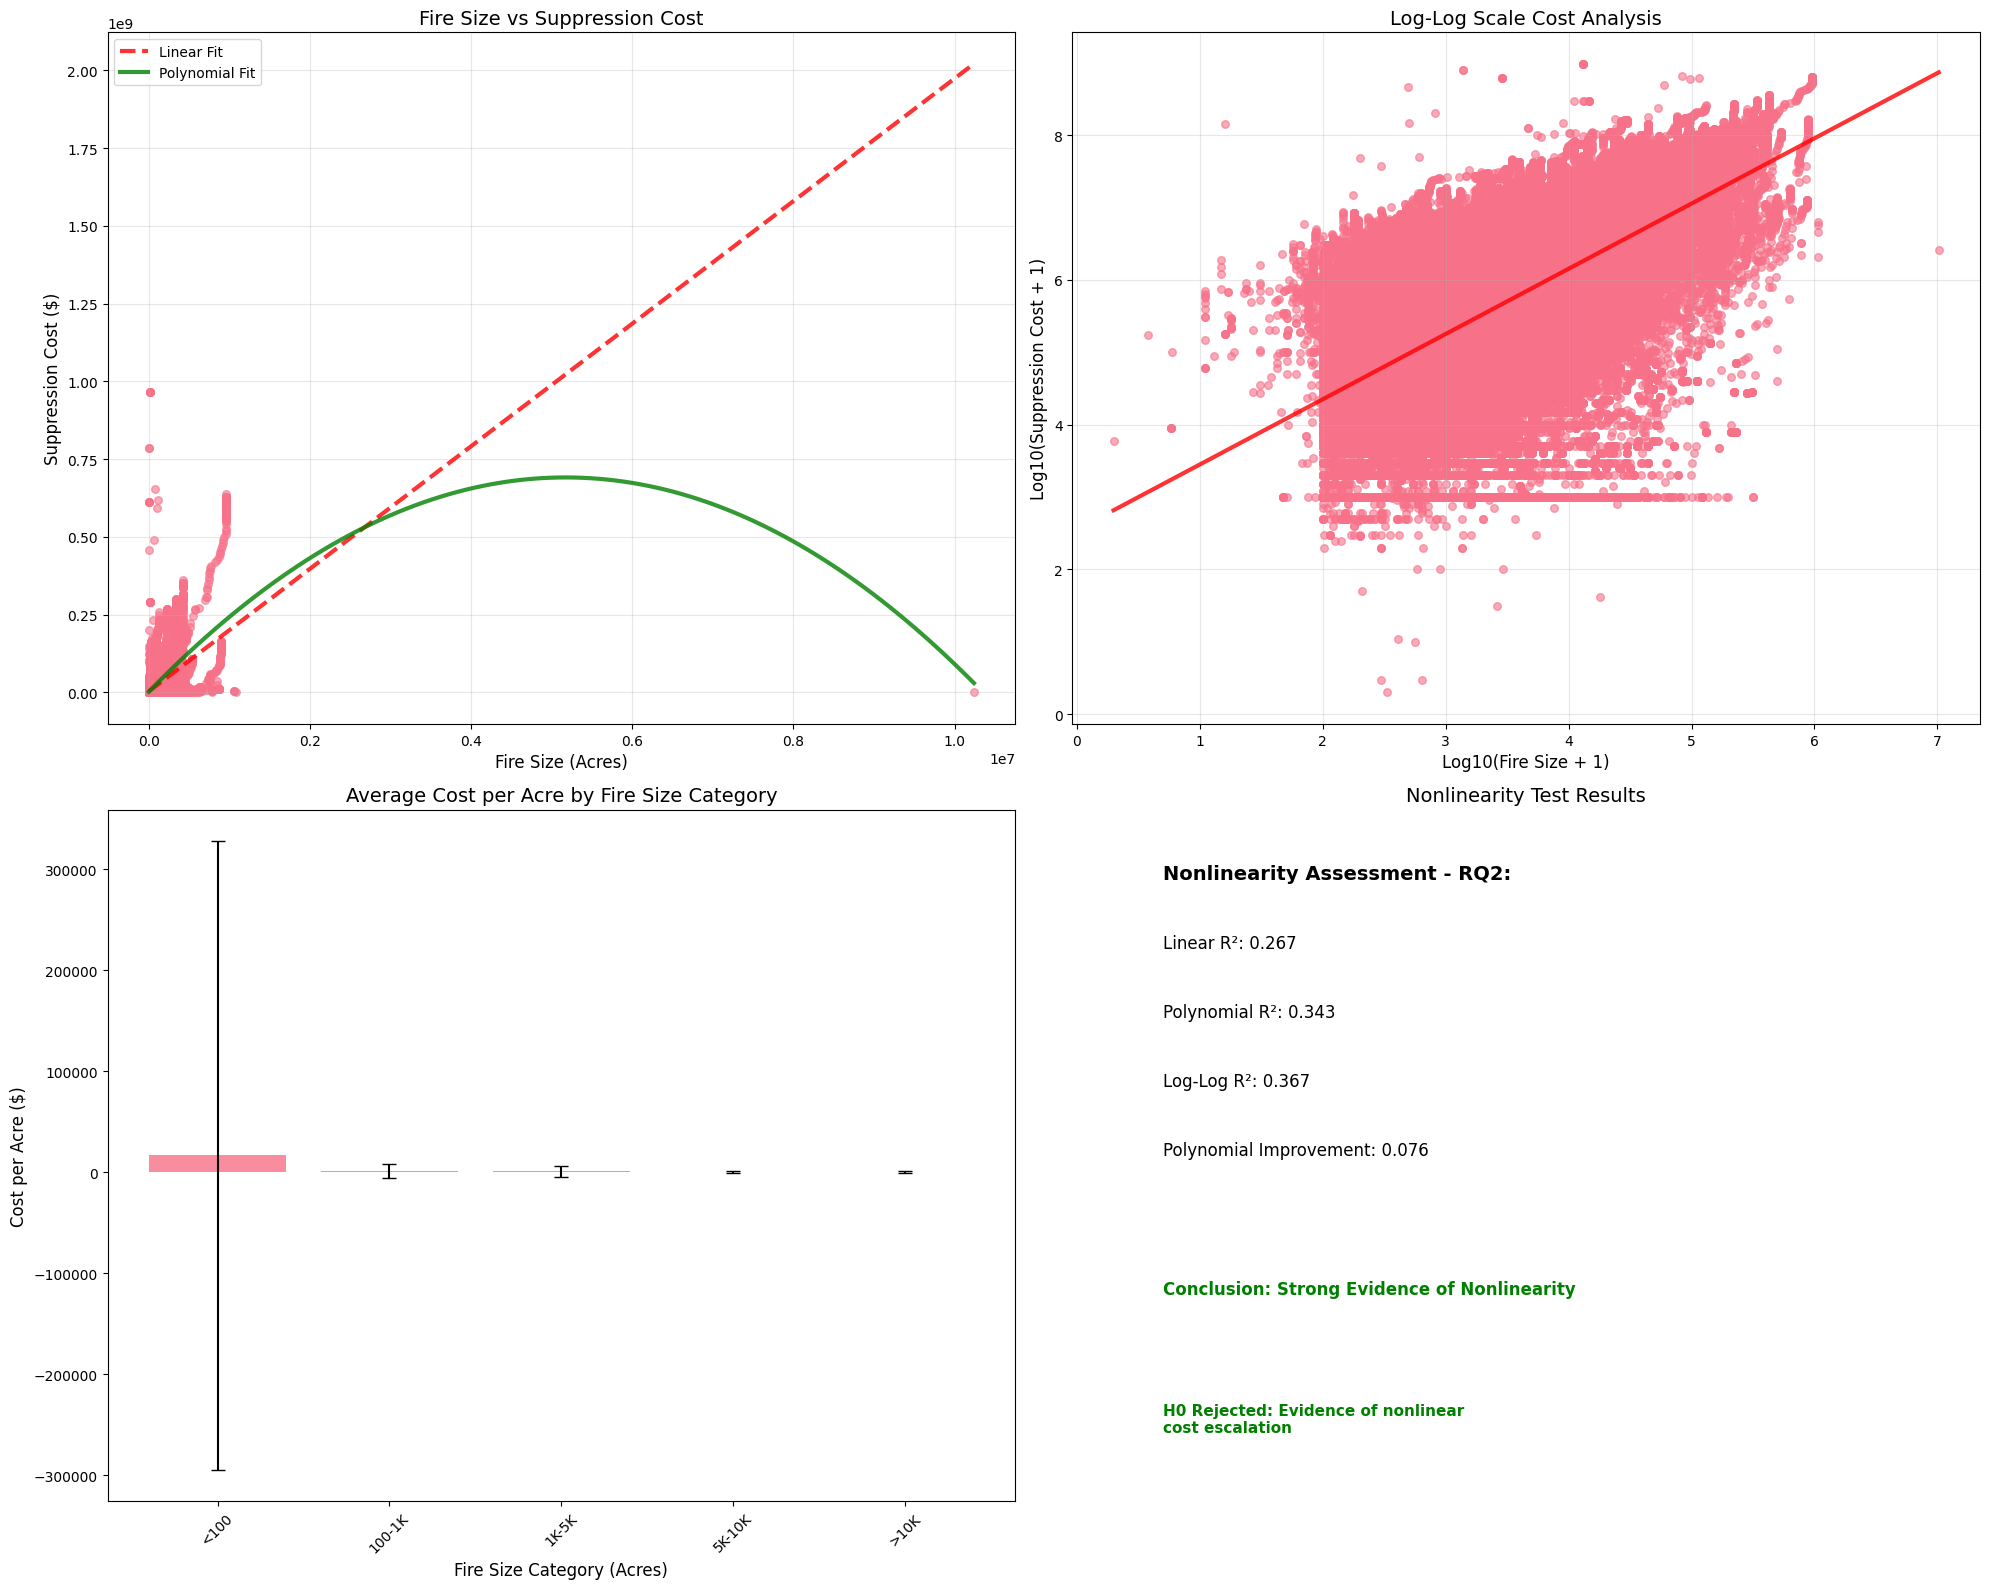

In [12]:
# Figure 2: Cost escalation analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

if 'fire_size_acres' in main_df.columns and 'suppression_cost' in main_df.columns:
    # Clean data for analysis
    cost_size_data = main_df[['fire_size_acres', 'suppression_cost']].dropna()
    cost_size_data = cost_size_data[(cost_size_data['fire_size_acres'] > 0) & (cost_size_data['suppression_cost'] > 0)]

    # Subplot 1: Scatter plot with regression lines
    x = cost_size_data['fire_size_acres']
    y = cost_size_data['suppression_cost']

    axes[0,0].scatter(x, y, alpha=0.6, s=30)

    # Linear fit
    z_linear = np.polyfit(x, y, 1)
    p_linear = np.poly1d(z_linear)

    # Polynomial fit
    z_poly = np.polyfit(x, y, 2)
    p_poly = np.poly1d(z_poly)

    x_smooth = np.linspace(x.min(), x.max(), 100)
    axes[0,0].plot(x_smooth, p_linear(x_smooth), "r--", alpha=0.8, linewidth=3, label='Linear Fit')
    axes[0,0].plot(x_smooth, p_poly(x_smooth), "g-", alpha=0.8, linewidth=3, label='Polynomial Fit')

    axes[0,0].set_xlabel('Fire Size (Acres)', fontsize=12)
    axes[0,0].set_ylabel('Suppression Cost ($)', fontsize=12)
    axes[0,0].set_title('Fire Size vs Suppression Cost', fontsize=14)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Subplot 2: Log-scale analysis
    log_x = np.log10(x + 1)  # Add 1 to handle zeros
    log_y = np.log10(y + 1)

    axes[0,1].scatter(log_x, log_y, alpha=0.6, s=30)

    # Log-log regression
    log_fit = np.polyfit(log_x, log_y, 1)
    log_line = np.poly1d(log_fit)
    x_log_smooth = np.linspace(log_x.min(), log_x.max(), 100)
    axes[0,1].plot(x_log_smooth, log_line(x_log_smooth), "r-", alpha=0.8, linewidth=3)

    axes[0,1].set_xlabel('Log10(Fire Size + 1)', fontsize=12)
    axes[0,1].set_ylabel('Log10(Suppression Cost + 1)', fontsize=12)
    axes[0,1].set_title('Log-Log Scale Cost Analysis', fontsize=14)
    axes[0,1].grid(True, alpha=0.3)

    # Subplot 3: Cost per acre analysis
    main_df['size_category'] = pd.cut(main_df['fire_size_acres'],
                                     bins=[0, 100, 1000, 5000, 10000, np.inf],
                                     labels=['<100', '100-1K', '1K-5K', '5K-10K', '>10K'])

    if 'cost_per_acre' in main_df.columns:
        cost_per_acre_stats = main_df.groupby('size_category')['cost_per_acre'].agg(['mean', 'std', 'count']).reset_index()
        cost_per_acre_stats = cost_per_acre_stats.dropna()

        axes[1,0].bar(cost_per_acre_stats['size_category'], cost_per_acre_stats['mean'],
                     yerr=cost_per_acre_stats['std'], capsize=5, alpha=0.8)
        axes[1,0].set_title('Average Cost per Acre by Fire Size Category', fontsize=14)
        axes[1,0].set_xlabel('Fire Size Category (Acres)', fontsize=12)
        axes[1,0].set_ylabel('Cost per Acre ($)', fontsize=12)
        axes[1,0].tick_params(axis='x', rotation=45)

    # Subplot 4: Nonlinearity assessment
    linear_r2 = stats.pearsonr(x, y)[0]**2

    # Calculate polynomial R²
    poly_pred = p_poly(x)
    poly_r2 = 1 - (np.sum((y - poly_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))

    # Power law fit R²
    log_r2 = stats.pearsonr(log_x, log_y)[0]**2

    axes[1,1].text(0.1, 0.9, 'Nonlinearity Assessment - RQ2:', transform=axes[1,1].transAxes, fontsize=14, weight='bold')
    axes[1,1].text(0.1, 0.8, f'Linear R²: {linear_r2:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.7, f'Polynomial R²: {poly_r2:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.6, f'Log-Log R²: {log_r2:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.5, f'Polynomial Improvement: {poly_r2 - linear_r2:.3f}', transform=axes[1,1].transAxes, fontsize=12)

    if poly_r2 - linear_r2 > 0.05:
        result = "Strong Evidence of Nonlinearity"
        color = 'green'
    elif poly_r2 - linear_r2 > 0.02:
        result = "Moderate Evidence of Nonlinearity"
        color = 'orange'
    else:
        result = "Weak Evidence of Nonlinearity"
        color = 'red'

    axes[1,1].text(0.1, 0.3, f'Conclusion: {result}', transform=axes[1,1].transAxes, fontsize=12,
                  color=color, weight='bold')

    if poly_r2 - linear_r2 > 0.02:
        axes[1,1].text(0.1, 0.1, 'H0 Rejected: Evidence of nonlinear\ncost escalation',
                      transform=axes[1,1].transAxes, fontsize=11, color='green', weight='bold')
    else:
        axes[1,1].text(0.1, 0.1, 'H0 Not Rejected: Linear relationship\ncannot be rejected',
                      transform=axes[1,1].transAxes, fontsize=11, color='red', weight='bold')

else:
    for i in range(4):
        axes.flat[i].text(0.5, 0.5, 'Cost and size data not available', ha='center', va='center',
                         transform=axes.flat[i].transAxes)
        axes.flat[i].set_title(f'Cost Analysis - Data Not Available')

axes[1,1].set_title('Nonlinearity Test Results', fontsize=14)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

## 3.2 Threshold Identification

In [13]:
# Identify cost escalation thresholds
if 'fire_size_acres' in main_df.columns and 'suppression_cost' in main_df.columns:
    thresholds = [500, 1000, 2500, 5000, 10000, 25000]
    threshold_results = []

    for threshold in thresholds:
        small_fires = main_df[main_df['fire_size_acres'] <= threshold]
        large_fires = main_df[main_df['fire_size_acres'] > threshold]

        if 'cost_per_acre' in main_df.columns:
            small_cost = small_fires['cost_per_acre'].dropna()
            large_cost = large_fires['cost_per_acre'].dropna()

            if len(small_cost) > 10 and len(large_cost) > 10:
                t_stat, p_val = stats.ttest_ind(small_cost, large_cost)

                threshold_results.append({
                    'Threshold (acres)': threshold,
                    'Small fires count': len(small_cost),
                    'Large fires count': len(large_cost),
                    'Small fires avg cost/acre': small_cost.mean(),
                    'Large fires avg cost/acre': large_cost.mean(),
                    'Cost ratio': large_cost.mean() / small_cost.mean(),
                    'T-statistic': t_stat,
                    'P-value': p_val,
                    'Significant (p<0.05)': p_val < 0.05
                })

    if threshold_results:
        threshold_df = pd.DataFrame(threshold_results)
        print("RQ2: Cost Escalation Threshold Analysis")
        print("="*60)
        print(threshold_df.round(3))

        # Find the most significant threshold
        significant_thresholds = threshold_df[threshold_df['Significant (p<0.05)']]
        if not significant_thresholds.empty:
            best_threshold = significant_thresholds.loc[significant_thresholds['Cost ratio'].idxmax()]
            print(f"\nMost significant threshold: {best_threshold['Threshold (acres)']} acres")
            print(f"Cost escalation ratio: {best_threshold['Cost ratio']:.2f}x")

RQ2: Cost Escalation Threshold Analysis
   Threshold (acres)  Small fires count  Large fires count  \
0                500              21502              80097   
1               1000              34198              67401   
2               2500              50052              51547   
3               5000              62002              39597   
4              10000              72156              29443   
5              25000              84556              17043   

   Small fires avg cost/acre  Large fires avg cost/acre  Cost ratio  \
0                   2592.997                    770.707       0.297   
1                   2037.909                    709.092       0.348   
2                   1710.788                    618.030       0.361   
3                   1559.838                    524.607       0.336   
4                   1435.002                    473.524       0.330   
5                   1313.204                    378.260       0.288   

   T-statistic  P-value  Si

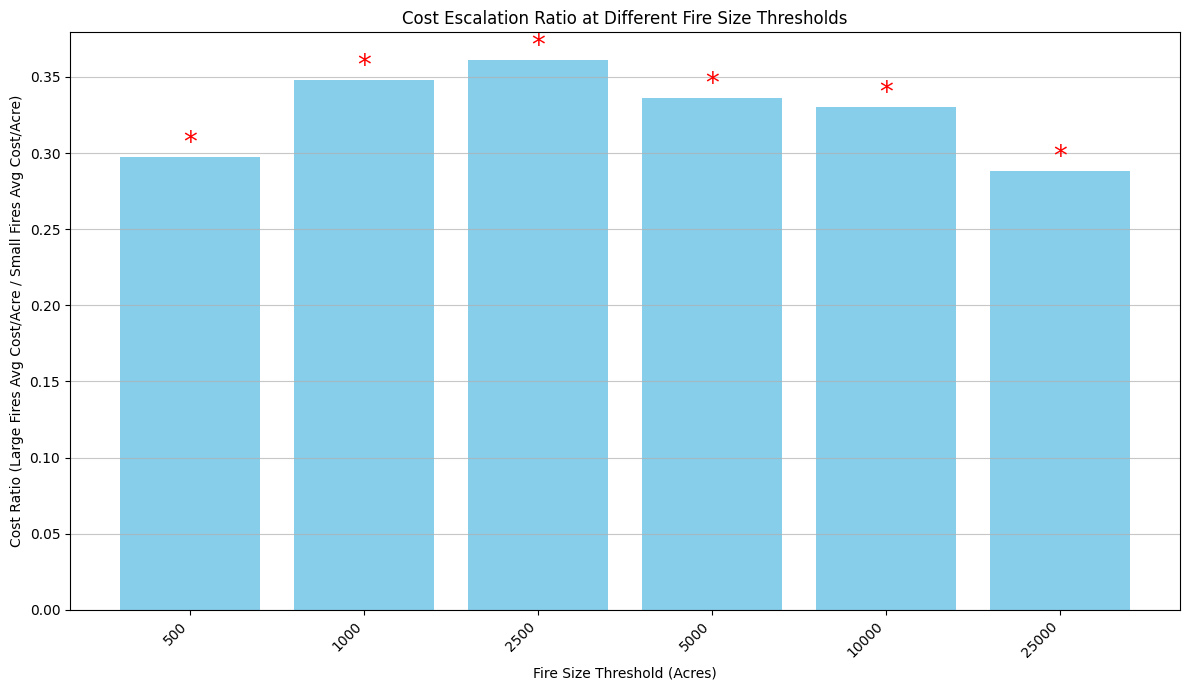

In [14]:
# Visualize cost escalation thresholds
if threshold_results:
    threshold_df = pd.DataFrame(threshold_results)

    plt.figure(figsize=(12, 7))
    bars = plt.bar(threshold_df['Threshold (acres)'].astype(str), threshold_df['Cost ratio'], color='skyblue')
    plt.xlabel('Fire Size Threshold (Acres)')
    plt.ylabel('Cost Ratio (Large Fires Avg Cost/Acre / Small Fires Avg Cost/Acre)')
    plt.title('Cost Escalation Ratio at Different Fire Size Thresholds')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.7)

    # Add significance stars
    for i, bar in enumerate(bars):
        if threshold_df['Significant (p<0.05)'].iloc[i]:
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), '*',
                     ha='center', va='bottom', color='red', fontsize=20)

    plt.tight_layout()
    plt.show()
else:
    print("No threshold results to visualize.")

# RQ3: Regional Resource Deployment Analysis


## 4.1 GACC Resource Analysis

GACC Data columns: ['imsr_date', 'gacc', 'gacc_priority', 'preparedness_level', 'new_fires', 'new_large_fires', 'uncontained_large_fires', 'area_command_teams', 'nimos', 'type_1_teams', 'type_2_teams', 'fire_use_teams', 'complex_teams']
Resource Data columns: ['imsr_date', 'gacc', 'incidents', 'cumulative_size', 'crews', 'engines', 'helicopters', 'personnel', 'personnel_change']
Resource columns (from resource_summary): ['crews', 'engines', 'helicopters', 'personnel']
Team columns (from gacc_activity): ['area_command_teams', 'nimos', 'type_1_teams', 'type_2_teams', 'fire_use_teams', 'complex_teams']
Fire-related columns: ['new_fires', 'new_large_fires', 'uncontained_large_fires']
Fire size columns: ['cumulative_size']
Successfully merged data: (11782, 20) records


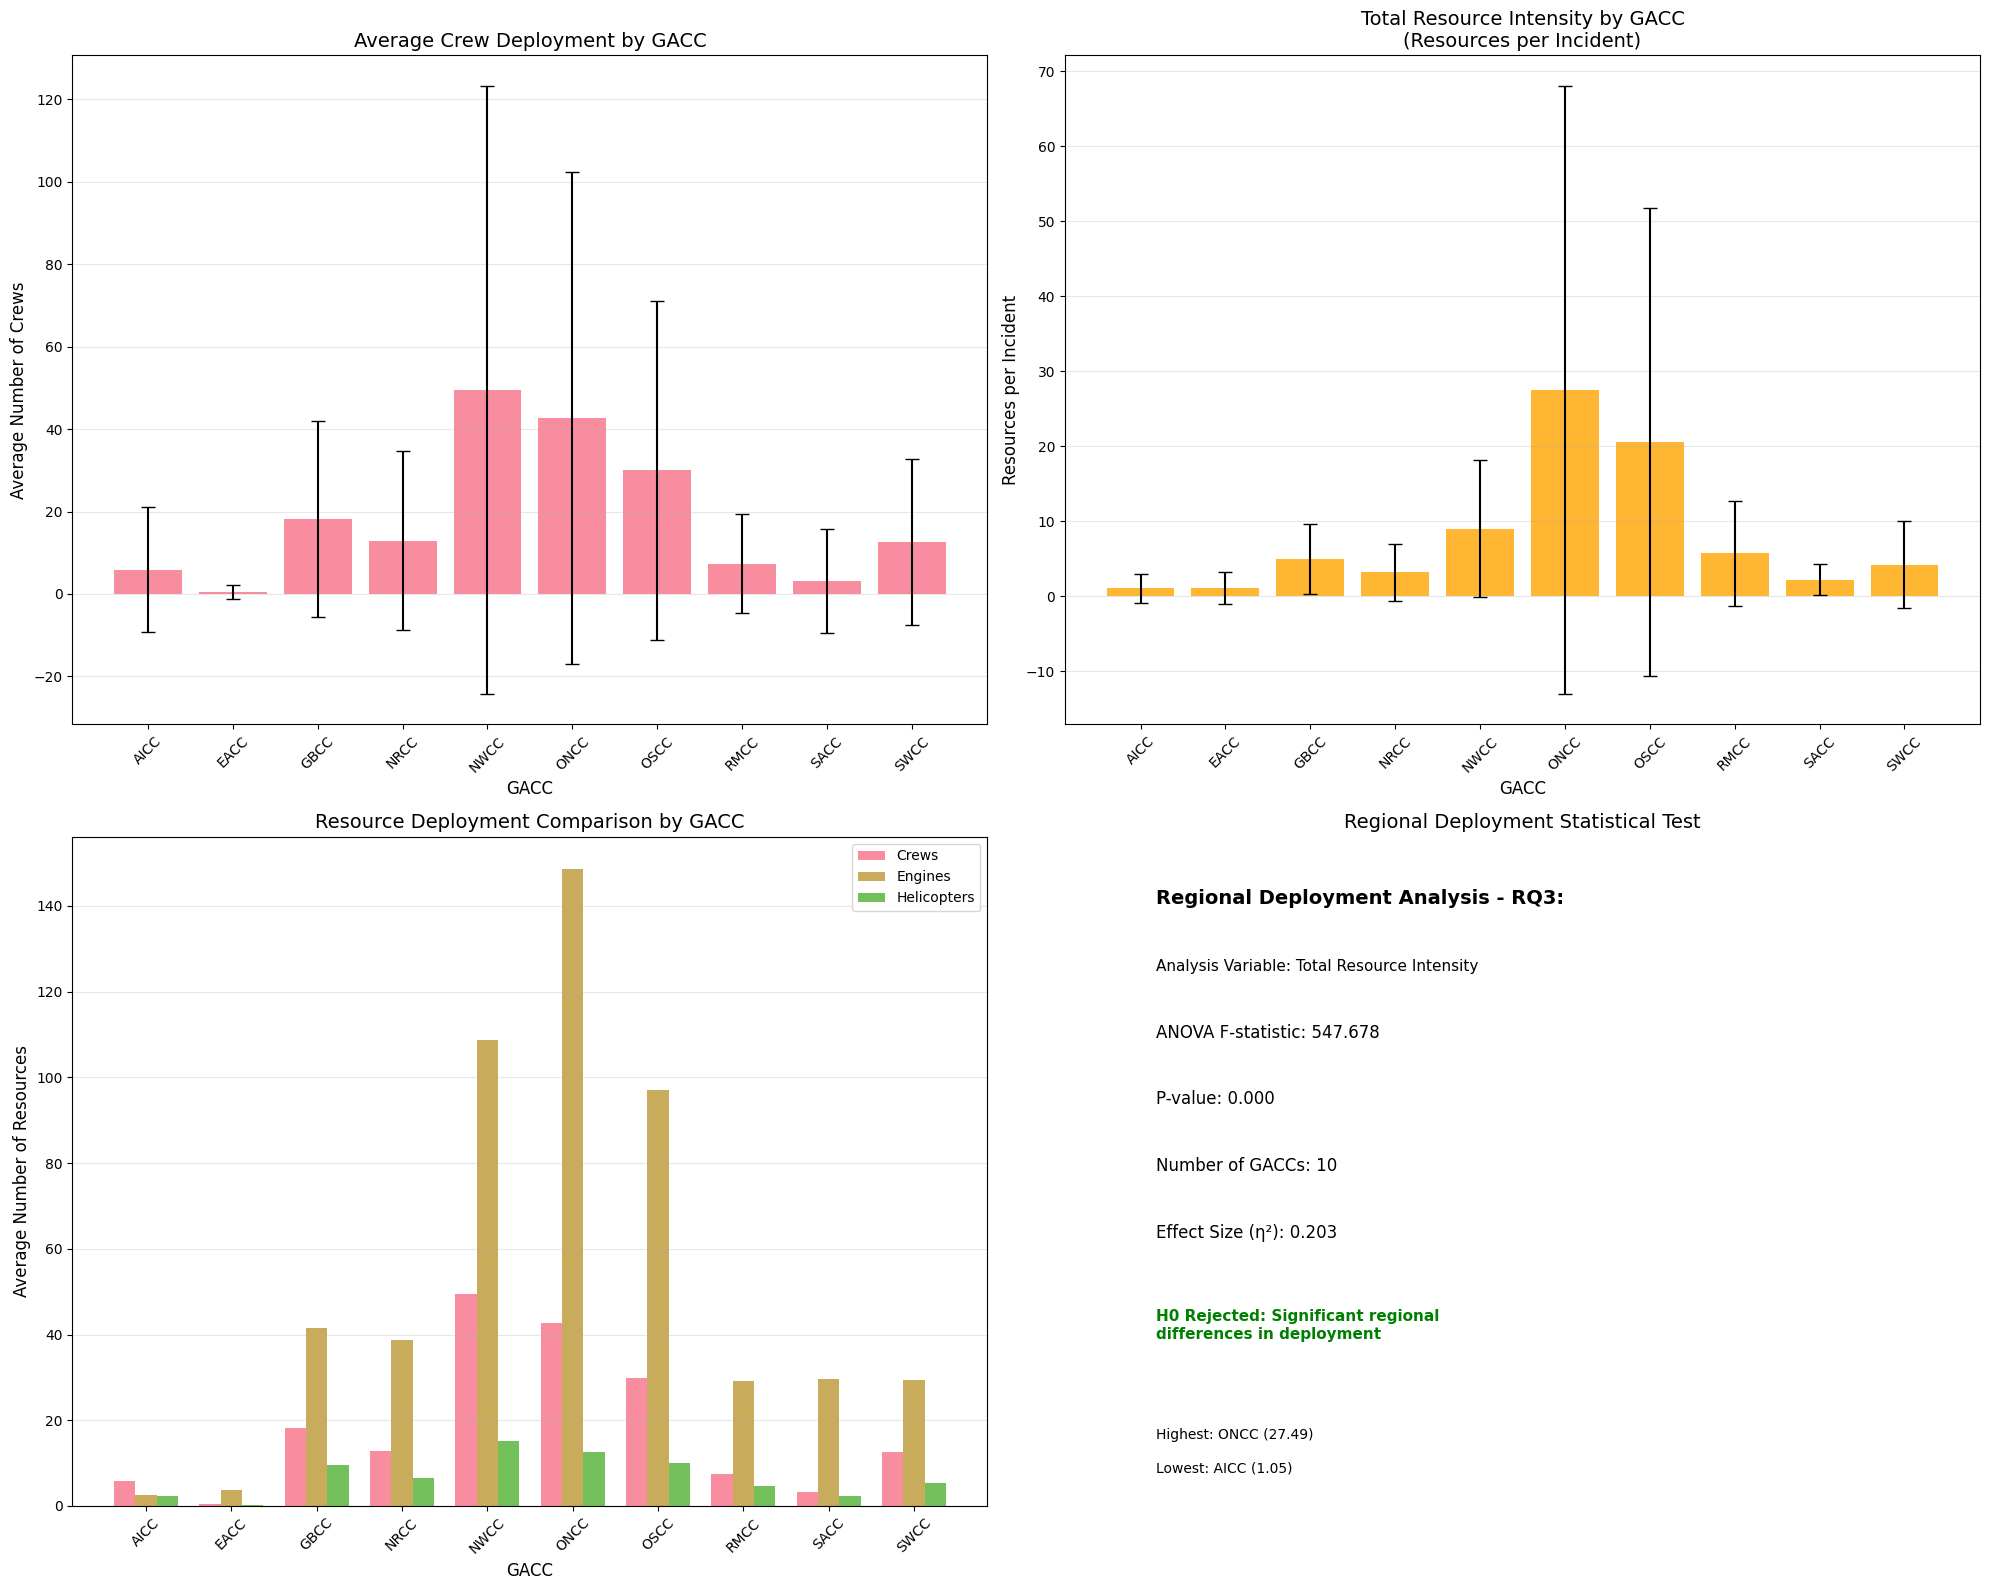

In [15]:
# Figure 3: Regional resource deployment analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Use GACC activity data and resource summary data for regional analysis
gacc_data = gacc_activity_df.copy()
resource_data = resource_summary_df.copy()

print("GACC Data columns:", list(gacc_data.columns))
print("Resource Data columns:", list(resource_data.columns))

# Properly identify columns based on your actual data structure
# Resource columns from resource_summary_df
resource_cols_from_summary = ['crews', 'engines', 'helicopters', 'personnel']
# Fire-related columns
fire_cols = ['new_fires', 'new_large_fires', 'uncontained_large_fires']
fire_size_cols = ['cumulative_size']  # From resource_summary
# GACC identifier
gacc_col = 'gacc'
# Team/resource columns from gacc_activity_df
team_cols = ['area_command_teams', 'nimos', 'type_1_teams', 'type_2_teams', 'fire_use_teams', 'complex_teams']

print("Resource columns (from resource_summary):", resource_cols_from_summary)
print("Team columns (from gacc_activity):", team_cols)
print("Fire-related columns:", fire_cols)
print("Fire size columns:", fire_size_cols)

# Merge gacc_activity and resource_summary data on common columns
if 'imsr_date' in gacc_data.columns and 'imsr_date' in resource_data.columns:
    # Merge on date and gacc
    combined_data = pd.merge(gacc_data, resource_data, on=['imsr_date', 'gacc'], how='inner', suffixes=('_gacc', '_resource'))
    print(f"Successfully merged data: {combined_data.shape} records")
else:
    print("Cannot merge data - using separate datasets")
    combined_data = gacc_data.copy()

# Subplot 1: Resource deployment by GACC (using resource_summary data)
if 'crews' in resource_data.columns and gacc_col in resource_data.columns:
    # Calculate average resources by GACC
    resource_by_gacc = resource_data.groupby(gacc_col)[['crews', 'engines', 'helicopters', 'personnel']].agg(['mean', 'std', 'count']).reset_index()

    # Flatten column names
    resource_by_gacc.columns = [gacc_col] + [f"{col[0]}_{col[1]}" for col in resource_by_gacc.columns[1:]]

    # Plot crews deployment
    axes[0,0].bar(resource_by_gacc[gacc_col], resource_by_gacc['crews_mean'],
                 yerr=resource_by_gacc['crews_std'], capsize=5, alpha=0.8)
    axes[0,0].set_title('Average Crew Deployment by GACC', fontsize=14)
    axes[0,0].set_xlabel('GACC', fontsize=12)
    axes[0,0].set_ylabel('Average Number of Crews', fontsize=12)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3, axis='y')
else:
    axes[0,0].text(0.5, 0.5, 'Crew deployment data not available', ha='center', va='center',
                   transform=axes[0,0].transAxes)
    axes[0,0].set_title('Crew Deployment - Data Not Available')

# Subplot 2: Resource intensity analysis (resources per incident or per cumulative size)
if 'crews' in resource_data.columns and 'incidents' in resource_data.columns:
    # Calculate resource intensity as resources per incident
    resource_data['crew_intensity'] = resource_data['crews'] / (resource_data['incidents'] + 1)  # +1 to avoid division by zero
    resource_data['engine_intensity'] = resource_data['engines'] / (resource_data['incidents'] + 1)
    resource_data['total_resource_intensity'] = (resource_data['crews'] + resource_data['engines'] + resource_data['helicopters']) / (resource_data['incidents'] + 1)

    intensity_by_gacc = resource_data.groupby(gacc_col)['total_resource_intensity'].agg(['mean', 'std', 'count']).reset_index()

    axes[0,1].bar(intensity_by_gacc[gacc_col], intensity_by_gacc['mean'],
                 yerr=intensity_by_gacc['std'], capsize=5, alpha=0.8, color='orange')
    axes[0,1].set_title('Total Resource Intensity by GACC\n(Resources per Incident)', fontsize=14)
    axes[0,1].set_xlabel('GACC', fontsize=12)
    axes[0,1].set_ylabel('Resources per Incident', fontsize=12)
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3, axis='y')

elif 'crews' in resource_data.columns and 'cumulative_size' in resource_data.columns:
    # Alternative: resources per cumulative size
    resource_data['size_intensity'] = (resource_data['crews'] + resource_data['engines']) / (resource_data['cumulative_size'] + 1)

    intensity_by_gacc = resource_data.groupby(gacc_col)['size_intensity'].agg(['mean', 'std']).reset_index()

    axes[0,1].bar(intensity_by_gacc[gacc_col], intensity_by_gacc['mean'],
                 yerr=intensity_by_gacc['std'], capsize=5, alpha=0.8, color='orange')
    axes[0,1].set_title('Resource Intensity by GACC\n(Resources per Fire Size)', fontsize=14)
    axes[0,1].set_xlabel('GACC', fontsize=12)
    axes[0,1].set_ylabel('Resources per Size Unit', fontsize=12)
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, 'Resource intensity calculation not possible', ha='center', va='center',
                   transform=axes[0,1].transAxes)
    axes[0,1].set_title('Resource Intensity - Data Not Available')

# Subplot 3: Multi-resource comparison by GACC
if all(col in resource_data.columns for col in ['crews', 'engines', 'helicopters']):
    # Create grouped bar chart for different resource types
    resource_means = resource_data.groupby(gacc_col)[['crews', 'engines', 'helicopters']].mean().reset_index()

    x = np.arange(len(resource_means))
    width = 0.25

    axes[1,0].bar(x - width, resource_means['crews'], width, label='Crews', alpha=0.8)
    axes[1,0].bar(x, resource_means['engines'], width, label='Engines', alpha=0.8)
    axes[1,0].bar(x + width, resource_means['helicopters'], width, label='Helicopters', alpha=0.8)

    axes[1,0].set_xlabel('GACC', fontsize=12)
    axes[1,0].set_ylabel('Average Number of Resources', fontsize=12)
    axes[1,0].set_title('Resource Deployment Comparison by GACC', fontsize=14)
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(resource_means[gacc_col], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3, axis='y')
else:
    # Fallback: use team data from gacc_activity
    if all(col in gacc_data.columns for col in ['type_1_teams', 'type_2_teams', 'area_command_teams']):
        team_means = gacc_data.groupby(gacc_col)[['type_1_teams', 'type_2_teams', 'area_command_teams']].mean().reset_index()

        x = np.arange(len(team_means))
        width = 0.25

        axes[1,0].bar(x - width, team_means['type_1_teams'], width, label='Type 1 Teams', alpha=0.8)
        axes[1,0].bar(x, team_means['type_2_teams'], width, label='Type 2 Teams', alpha=0.8)
        axes[1,0].bar(x + width, team_means['area_command_teams'], width, label='Area Command Teams', alpha=0.8)

        axes[1,0].set_xlabel('GACC', fontsize=12)
        axes[1,0].set_ylabel('Average Number of Teams', fontsize=12)
        axes[1,0].set_title('Team Deployment Comparison by GACC', fontsize=14)
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(team_means[gacc_col], rotation=45)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3, axis='y')

# Subplot 4: Statistical test for regional differences
test_results_available = False

# Test with resource data if available
if 'total_resource_intensity' in resource_data.columns:
    gacc_groups = [resource_data[resource_data[gacc_col] == gacc]['total_resource_intensity'].dropna()
                   for gacc in resource_data[gacc_col].unique()]
    gacc_groups = [group for group in gacc_groups if len(group) > 1]
    test_data_name = "Total Resource Intensity"
    test_results_available = True

elif 'crews' in resource_data.columns:
    gacc_groups = [resource_data[resource_data[gacc_col] == gacc]['crews'].dropna()
                   for gacc in resource_data[gacc_col].unique()]
    gacc_groups = [group for group in gacc_groups if len(group) > 1]
    test_data_name = "Crew Deployment"
    test_results_available = True

elif 'type_1_teams' in gacc_data.columns:
    gacc_groups = [gacc_data[gacc_data[gacc_col] == gacc]['type_1_teams'].dropna()
                   for gacc in gacc_data[gacc_col].unique()]
    gacc_groups = [group for group in gacc_groups if len(group) > 1]
    test_data_name = "Type 1 Team Deployment"
    test_results_available = True

if test_results_available and len(gacc_groups) > 2:
    f_stat, p_val = stats.f_oneway(*gacc_groups)

    axes[1,1].text(0.1, 0.9, 'Regional Deployment Analysis - RQ3:', transform=axes[1,1].transAxes,
                  fontsize=14, weight='bold')
    axes[1,1].text(0.1, 0.8, f'Analysis Variable: {test_data_name}', transform=axes[1,1].transAxes, fontsize=11)
    axes[1,1].text(0.1, 0.7, f'ANOVA F-statistic: {f_stat:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.6, f'P-value: {p_val:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.5, f'Number of GACCs: {len(gacc_groups)}', transform=axes[1,1].transAxes, fontsize=12)

    # Effect size calculation
    all_values = np.concatenate(gacc_groups)
    overall_mean = all_values.mean()
    ss_between = sum(len(group) * (group.mean() - overall_mean)**2 for group in gacc_groups)
    ss_total = sum((all_values - overall_mean)**2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    axes[1,1].text(0.1, 0.4, f'Effect Size (η²): {eta_squared:.3f}', transform=axes[1,1].transAxes, fontsize=12)

    if p_val < 0.05:
        axes[1,1].text(0.1, 0.25, 'H0 Rejected: Significant regional\ndifferences in deployment',
                      transform=axes[1,1].transAxes, fontsize=11, color='green', weight='bold')

        # Post-hoc analysis - find most and least intensive GACCs
        if test_data_name == "Total Resource Intensity" and 'total_resource_intensity' in resource_data.columns:
            gacc_means = resource_data.groupby(gacc_col)['total_resource_intensity'].mean().sort_values(ascending=False)
        elif test_data_name == "Crew Deployment":
            gacc_means = resource_data.groupby(gacc_col)['crews'].mean().sort_values(ascending=False)
        else:
            gacc_means = gacc_data.groupby(gacc_col)['type_1_teams'].mean().sort_values(ascending=False)

        axes[1,1].text(0.1, 0.1, f'Highest: {gacc_means.index[0]} ({gacc_means.iloc[0]:.2f})',
                      transform=axes[1,1].transAxes, fontsize=10)
        axes[1,1].text(0.1, 0.05, f'Lowest: {gacc_means.index[-1]} ({gacc_means.iloc[-1]:.2f})',
                      transform=axes[1,1].transAxes, fontsize=10)
    else:
        axes[1,1].text(0.1, 0.25, 'H0 Not Rejected: No significant\nregional differences found',
                      transform=axes[1,1].transAxes, fontsize=11, color='red', weight='bold')

        # Show the range of values
        all_means = [np.mean(group) for group in gacc_groups]
        axes[1,1].text(0.1, 0.1, f'Value range: {min(all_means):.2f} - {max(all_means):.2f}',
                      transform=axes[1,1].transAxes, fontsize=10)

else:
    axes[1,1].text(0.5, 0.5, 'Insufficient data for\nstatistical comparison',
                  ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].text(0.5, 0.3, f'Available GACCs: {len(gacc_groups) if test_results_available else "Unknown"}',
                  ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
axes[1,1].set_title('Regional Deployment Statistical Test', fontsize=14)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

## 4.2 Resource Efficiency Comparison

In [16]:
# Resource efficiency analysis by GACC
# Check if resource_data and gacc_col variables are defined
if 'gacc' in resource_data.columns and 'crews' in resource_data.columns:
    gacc_col = 'gacc' # Assuming 'gacc' is the correct column name for GACC identifier

    # Identify resource and fire columns from resource_data if available, otherwise use gacc_data
    if 'crews' in resource_data.columns:
        resource_cols = ['crews', 'engines', 'helicopters', 'personnel']
        fire_cols_for_efficiency = ['incidents', 'cumulative_size'] # Use fire metrics from resource_data
        data_for_efficiency = resource_data.copy()
    else:
         # Fallback to gacc_data if resource_data is not suitable
        resource_cols = ['type_1_teams', 'type_2_teams', 'area_command_teams']
        fire_cols_for_efficiency = ['new_fires', 'new_large_fires', 'uncontained_large_fires']
        data_for_efficiency = gacc_data.copy()

    # Calculate comprehensive efficiency metrics
    # Ensure all columns for aggregation exist in the selected data
    cols_to_agg = [col for col in resource_cols + fire_cols_for_efficiency if col in data_for_efficiency.columns]

    if gacc_col in data_for_efficiency.columns and cols_to_agg:
         efficiency_metrics = data_for_efficiency.groupby(gacc_col).agg({
            col: ['mean', 'std', 'count'] for col in cols_to_agg
        }).round(3)

         print("RQ3: Regional Resource Deployment Efficiency")
         print("="*70)
         print(efficiency_metrics)

         # Create efficiency ranking based on a relevant metric (e.g., total resource intensity)
         if 'total_resource_intensity' in data_for_efficiency.columns:
            efficiency_ranking = data_for_efficiency.groupby(gacc_col)['total_resource_intensity'].agg(['mean', 'std', 'count']).reset_index()
            efficiency_ranking = efficiency_ranking.sort_values('mean', ascending=False)
            efficiency_ranking['efficiency_rank'] = range(1, len(efficiency_ranking) + 1)

            print("\nGACC Resource Deployment Ranking (Highest to Lowest Intensity):")
            # Ensure the GACC column name is correct for display
            print(efficiency_ranking[[gacc_col, 'mean', 'std', 'count', 'efficiency_rank']].to_string(index=False))
         else:
             print("\n'total_resource_intensity' not available for ranking.")
    else:
        print("Insufficient columns available for efficiency metrics calculation.")
else:
    print("Required data (resource_data or gacc_data with 'gacc' and resource columns) is not available for efficiency analysis.")

RQ3: Regional Resource Deployment Efficiency
       crews                engines                helicopters                \
        mean     std count     mean      std count        mean     std count   
gacc                                                                           
AICC   5.914  15.224  1936    2.465    7.400  1936       2.245   5.372  1936   
EACC   0.448   1.770  1936    3.621    9.028  1936       0.280   0.909  1936   
GBCC  18.104  23.746  1936   41.578   55.251  1936       9.619  11.200  1936   
NRCC  12.924  21.728  1936   38.645   73.479  1936       6.504  10.899  1936   
NWCC  49.501  73.788  1936  108.713  166.818  1936      15.139  21.500  1936   
ONCC  42.712  59.613  1936  148.663  252.780  1936      12.686  20.176  1936   
OSCC  29.965  41.116  1936   97.145  167.707  1936      10.106  13.817  1936   
RMCC   7.372  12.091  1936   29.104   44.096  1936       4.775   7.790  1936   
SACC   3.184  12.602  1936   29.604   49.429  1936       2.242   4.294  193

# RQ4: Predictive Analysis of High-Cost Events


## 5.1 High-Cost Event Classification Analysis

Key predictors identified: ['contained_large_fires', 'uncontained_large_fires', 'fire_size_acres', 'preparedness_level']
RQ4: Predictive Model Results
Model AUC Score: 0.870
Dataset size: 115059 records
High-cost event rate: 39.090%

Feature Importance Rankings:
                feature  importance
        fire_size_acres    0.730006
uncontained_large_fires    0.153687
  contained_large_fires    0.067380
     preparedness_level    0.048928

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     21042
           1       0.74      0.70      0.72     13476

    accuracy                           0.79     34518
   macro avg       0.78      0.77      0.78     34518
weighted avg       0.79      0.79      0.79     34518



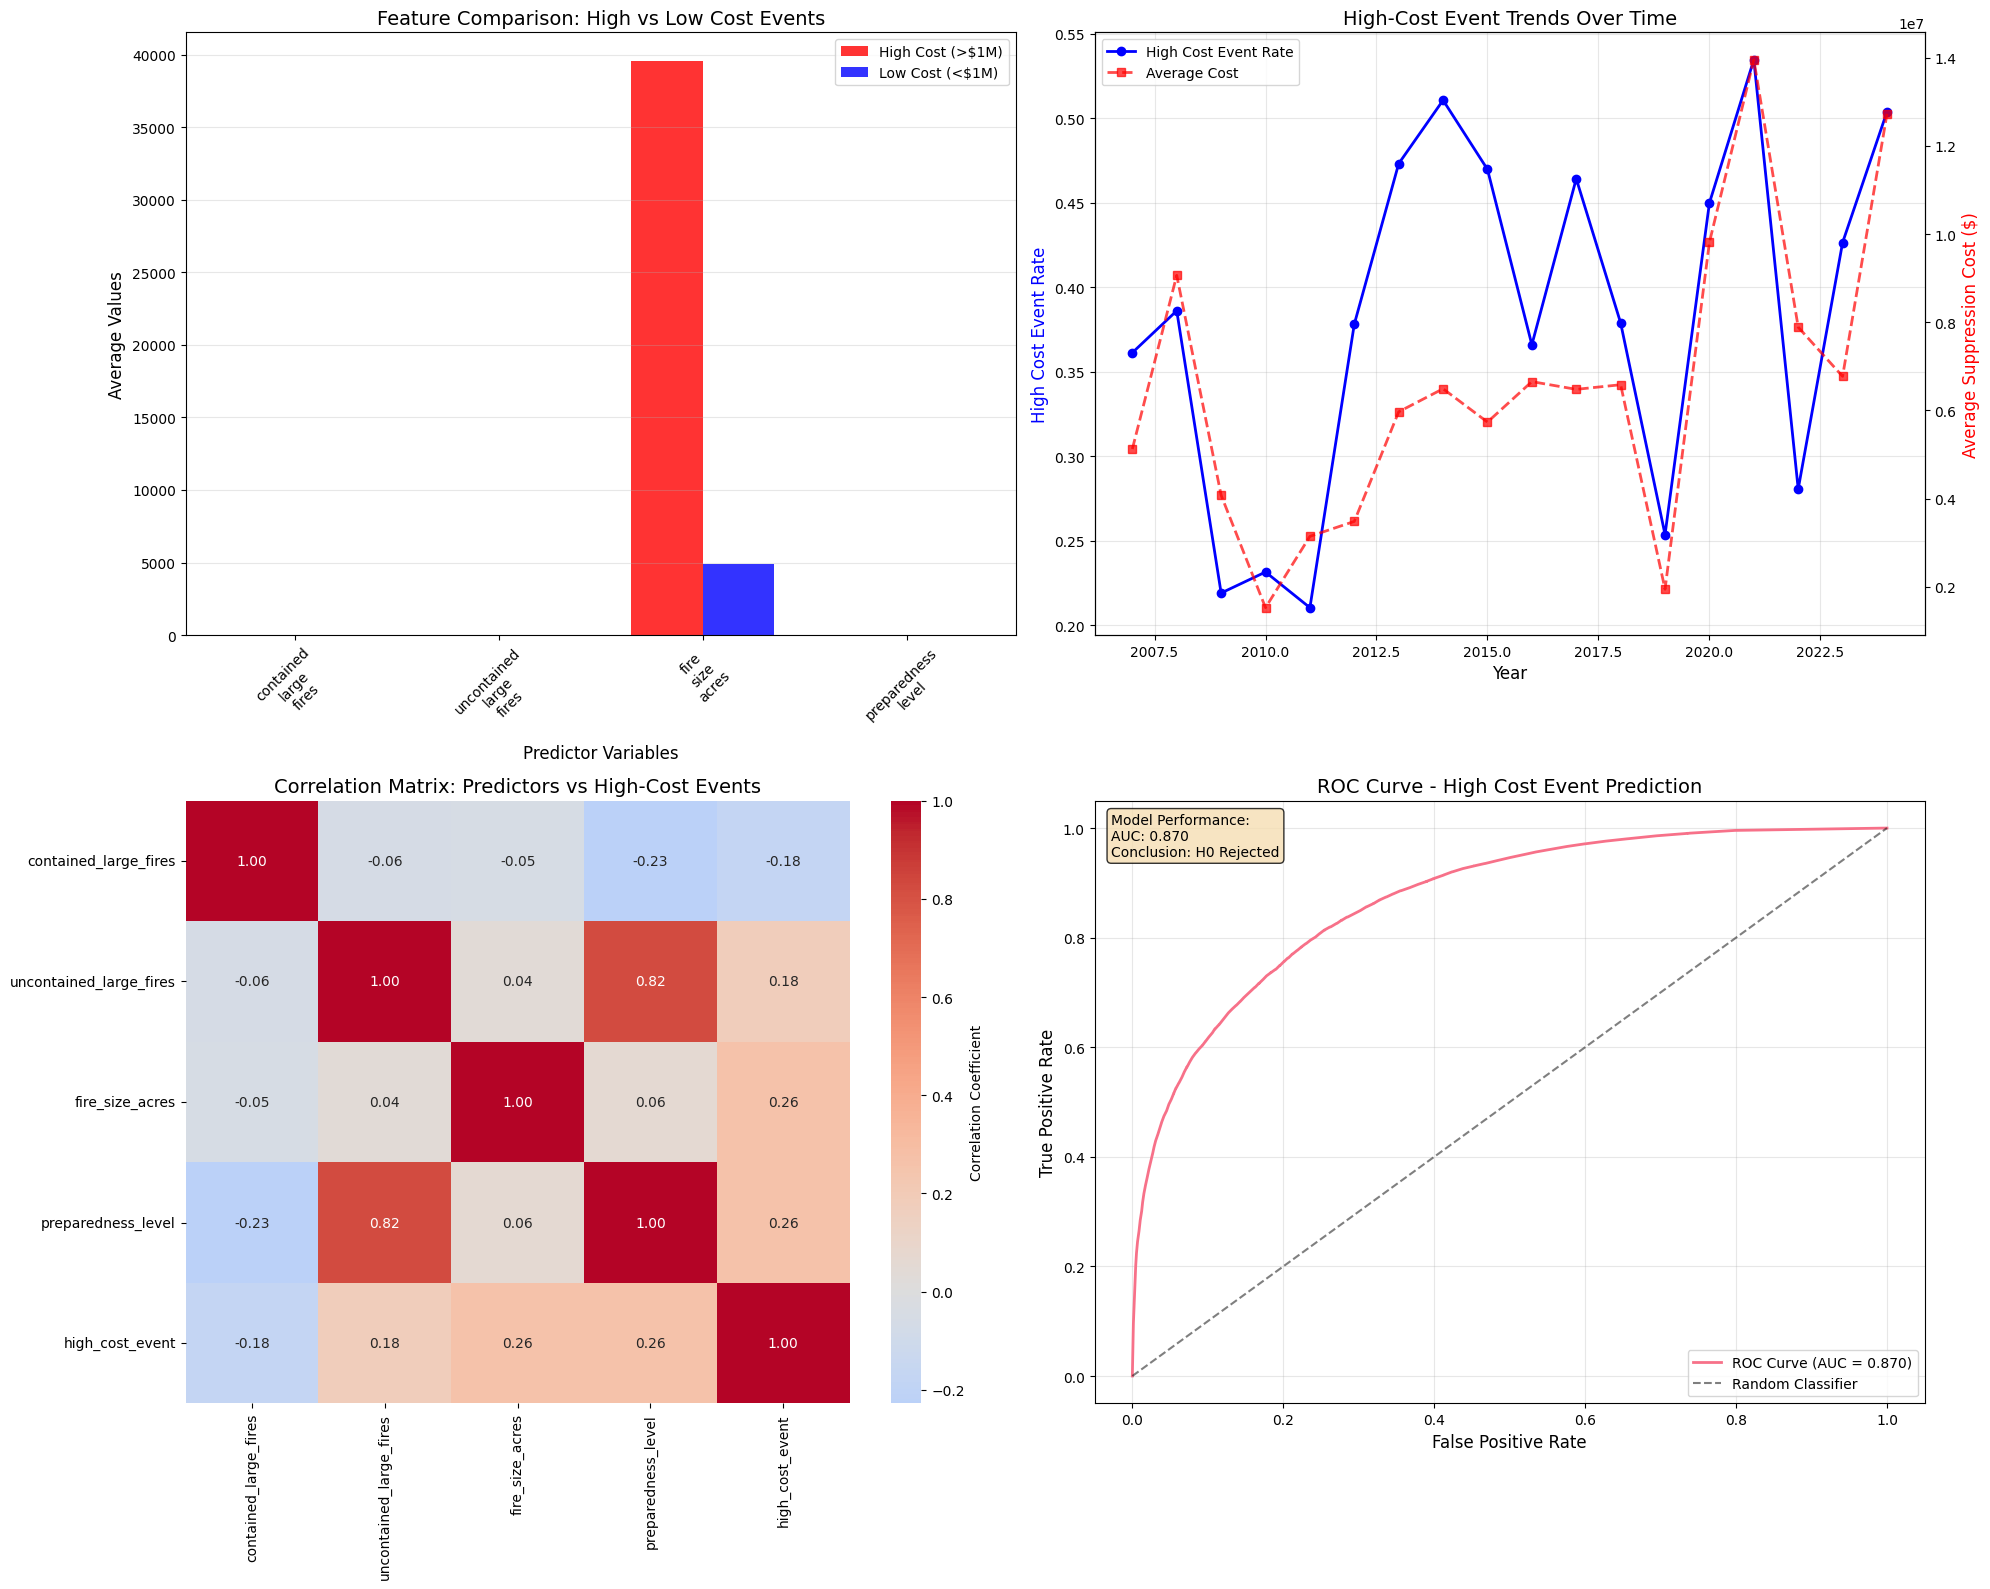

In [17]:
# RQ4: Predictive Analysis of High-Cost Events
# Figure 4: High-cost event prediction analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Prepare predictive features
if 'suppression_cost' in main_df.columns:
    # Define high-cost threshold (>$1M)
    main_df['high_cost_event'] = (main_df['suppression_cost'] > 1000000).astype(int)

    # Identify potential predictor variables
    predictor_cols = [col for col in main_df.columns if main_df[col].dtype in ['int64', 'float64']
                     and col not in ['suppression_cost', 'high_cost_event']]

    # Select key predictors based on common fire management variables
    key_predictors = []
    for term in ['size', 'contain', 'personnel', 'crew', 'engine', 'prep', 'duration']:
        matching_cols = [col for col in predictor_cols if term in col.lower()]
        if matching_cols:
            key_predictors.extend(matching_cols[:2])  # Take up to 2 columns per category

    key_predictors = list(set(key_predictors))[:6]  # Limit to 6 predictors for clarity

    print("Key predictors identified:", key_predictors)

    if key_predictors and len(key_predictors) >= 3:
        # Subplot 1: Feature importance comparison
        high_cost = main_df[main_df['high_cost_event'] == 1][key_predictors].mean()
        low_cost = main_df[main_df['high_cost_event'] == 0][key_predictors].mean()

        x_pos = np.arange(len(key_predictors))
        width = 0.35

        axes[0,0].bar(x_pos - width/2, high_cost.values, width, label='High Cost (>$1M)', alpha=0.8, color='red')
        axes[0,0].bar(x_pos + width/2, low_cost.values, width, label='Low Cost (<$1M)', alpha=0.8, color='blue')

        axes[0,0].set_xlabel('Predictor Variables', fontsize=12)
        axes[0,0].set_ylabel('Average Values', fontsize=12)
        axes[0,0].set_title('Feature Comparison: High vs Low Cost Events', fontsize=14)
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels([col.replace('_', '\n') for col in key_predictors], rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3, axis='y')

        # Subplot 2: Distribution of high-cost events over time
        if 'fire_year' in main_df.columns:
            yearly_high_cost = main_df.groupby('fire_year').agg({
                'high_cost_event': ['sum', 'count'],
                'suppression_cost': 'mean'
            }).reset_index()

            yearly_high_cost.columns = ['fire_year', 'high_cost_count', 'total_fires', 'avg_cost']
            yearly_high_cost['high_cost_rate'] = yearly_high_cost['high_cost_count'] / yearly_high_cost['total_fires']

            ax2 = axes[0,1]
            ax2_twin = ax2.twinx()

            line1 = ax2.plot(yearly_high_cost['fire_year'], yearly_high_cost['high_cost_rate'],
                            'b-o', linewidth=2, label='High Cost Event Rate')
            line2 = ax2_twin.plot(yearly_high_cost['fire_year'], yearly_high_cost['avg_cost'],
                                 'r--s', linewidth=2, label='Average Cost', alpha=0.7)

            ax2.set_xlabel('Year', fontsize=12)
            ax2.set_ylabel('High Cost Event Rate', fontsize=12, color='blue')
            ax2_twin.set_ylabel('Average Suppression Cost ($)', fontsize=12, color='red')
            ax2.set_title('High-Cost Event Trends Over Time', fontsize=14)

            # Combine legends
            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            ax2.grid(True, alpha=0.3)

        # Subplot 3: Correlation matrix of predictors with high-cost events
        correlation_data = main_df[key_predictors + ['high_cost_event']].corr()

        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
                   fmt='.2f', ax=axes[1,0], cbar_kws={'label': 'Correlation Coefficient'})
        axes[1,0].set_title('Correlation Matrix: Predictors vs High-Cost Events', fontsize=14)

        # Subplot 4: Predictive model results
        # Prepare data for modeling
        model_data = main_df[key_predictors + ['high_cost_event']].dropna()

        if len(model_data) > 100:  # Ensure sufficient data
            X = model_data[key_predictors]
            y = model_data['high_cost_event']

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

            # Random Forest model
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)

            # Predictions and metrics
            y_pred = rf_model.predict(X_test)
            y_prob = rf_model.predict_proba(X_test)[:, 1]

            roc_auc = roc_auc_score(y_test, y_prob)
            fpr, tpr, _ = roc_curve(y_test, y_prob)

            # Plot ROC curve
            axes[1,1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
            axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
            axes[1,1].set_xlabel('False Positive Rate', fontsize=12)
            axes[1,1].set_ylabel('True Positive Rate', fontsize=12)
            axes[1,1].set_title('ROC Curve - High Cost Event Prediction', fontsize=14)
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

            # Feature importance
            feature_importance = pd.DataFrame({
                'feature': key_predictors,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("RQ4: Predictive Model Results")
            print("="*50)
            print(f"Model AUC Score: {roc_auc:.3f}")
            print(f"Dataset size: {len(model_data)} records")
            print(f"High-cost event rate: {y.mean():.3%}")
            print("\nFeature Importance Rankings:")
            print(feature_importance.to_string(index=False))

            # Classification report
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Hypothesis test conclusion
            if roc_auc > 0.7:
                conclusion = "H0 Rejected: Early indicators are\npredictive of high-cost events"
                color = 'green'
            elif roc_auc > 0.6:
                conclusion = "Moderate predictive ability found"
                color = 'orange'
            else:
                conclusion = "H0 Not Rejected: Weak predictive\nability of early indicators"
                color = 'red'

            # Add text box with results summary
            textstr = f'Model Performance:\nAUC: {roc_auc:.3f}\nConclusion: {conclusion.split(":")[0]}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            axes[1,1].text(0.02, 0.98, textstr, transform=axes[1,1].transAxes, fontsize=10,
                          verticalalignment='top', bbox=props)

        else:
            axes[1,1].text(0.5, 0.5, 'Insufficient data for\npredictive modeling',
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Predictive Model - Insufficient Data')

    else:
        for i in range(4):
            axes.flat[i].text(0.5, 0.5, 'Insufficient predictor variables identified',
                             ha='center', va='center', transform=axes.flat[i].transAxes)

else:
    for i in range(4):
        axes.flat[i].text(0.5, 0.5, 'Cost data not available for prediction',
                         ha='center', va='center', transform=axes.flat[i].transAxes)

plt.tight_layout()
plt.show()

Key predictors identified: ['contained_large_fires', 'uncontained_large_fires', 'fire_size_acres', 'preparedness_level']
RQ4: Predictive Model Results
Model AUC Score: 0.870
Dataset size: 115059 records
High-cost event rate: 39.090%

Feature Importance Rankings:
                feature  importance
        fire_size_acres    0.730006
uncontained_large_fires    0.153687
  contained_large_fires    0.067380
     preparedness_level    0.048928

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     21042
           1       0.74      0.70      0.72     13476

    accuracy                           0.79     34518
   macro avg       0.78      0.77      0.78     34518
weighted avg       0.79      0.79      0.79     34518



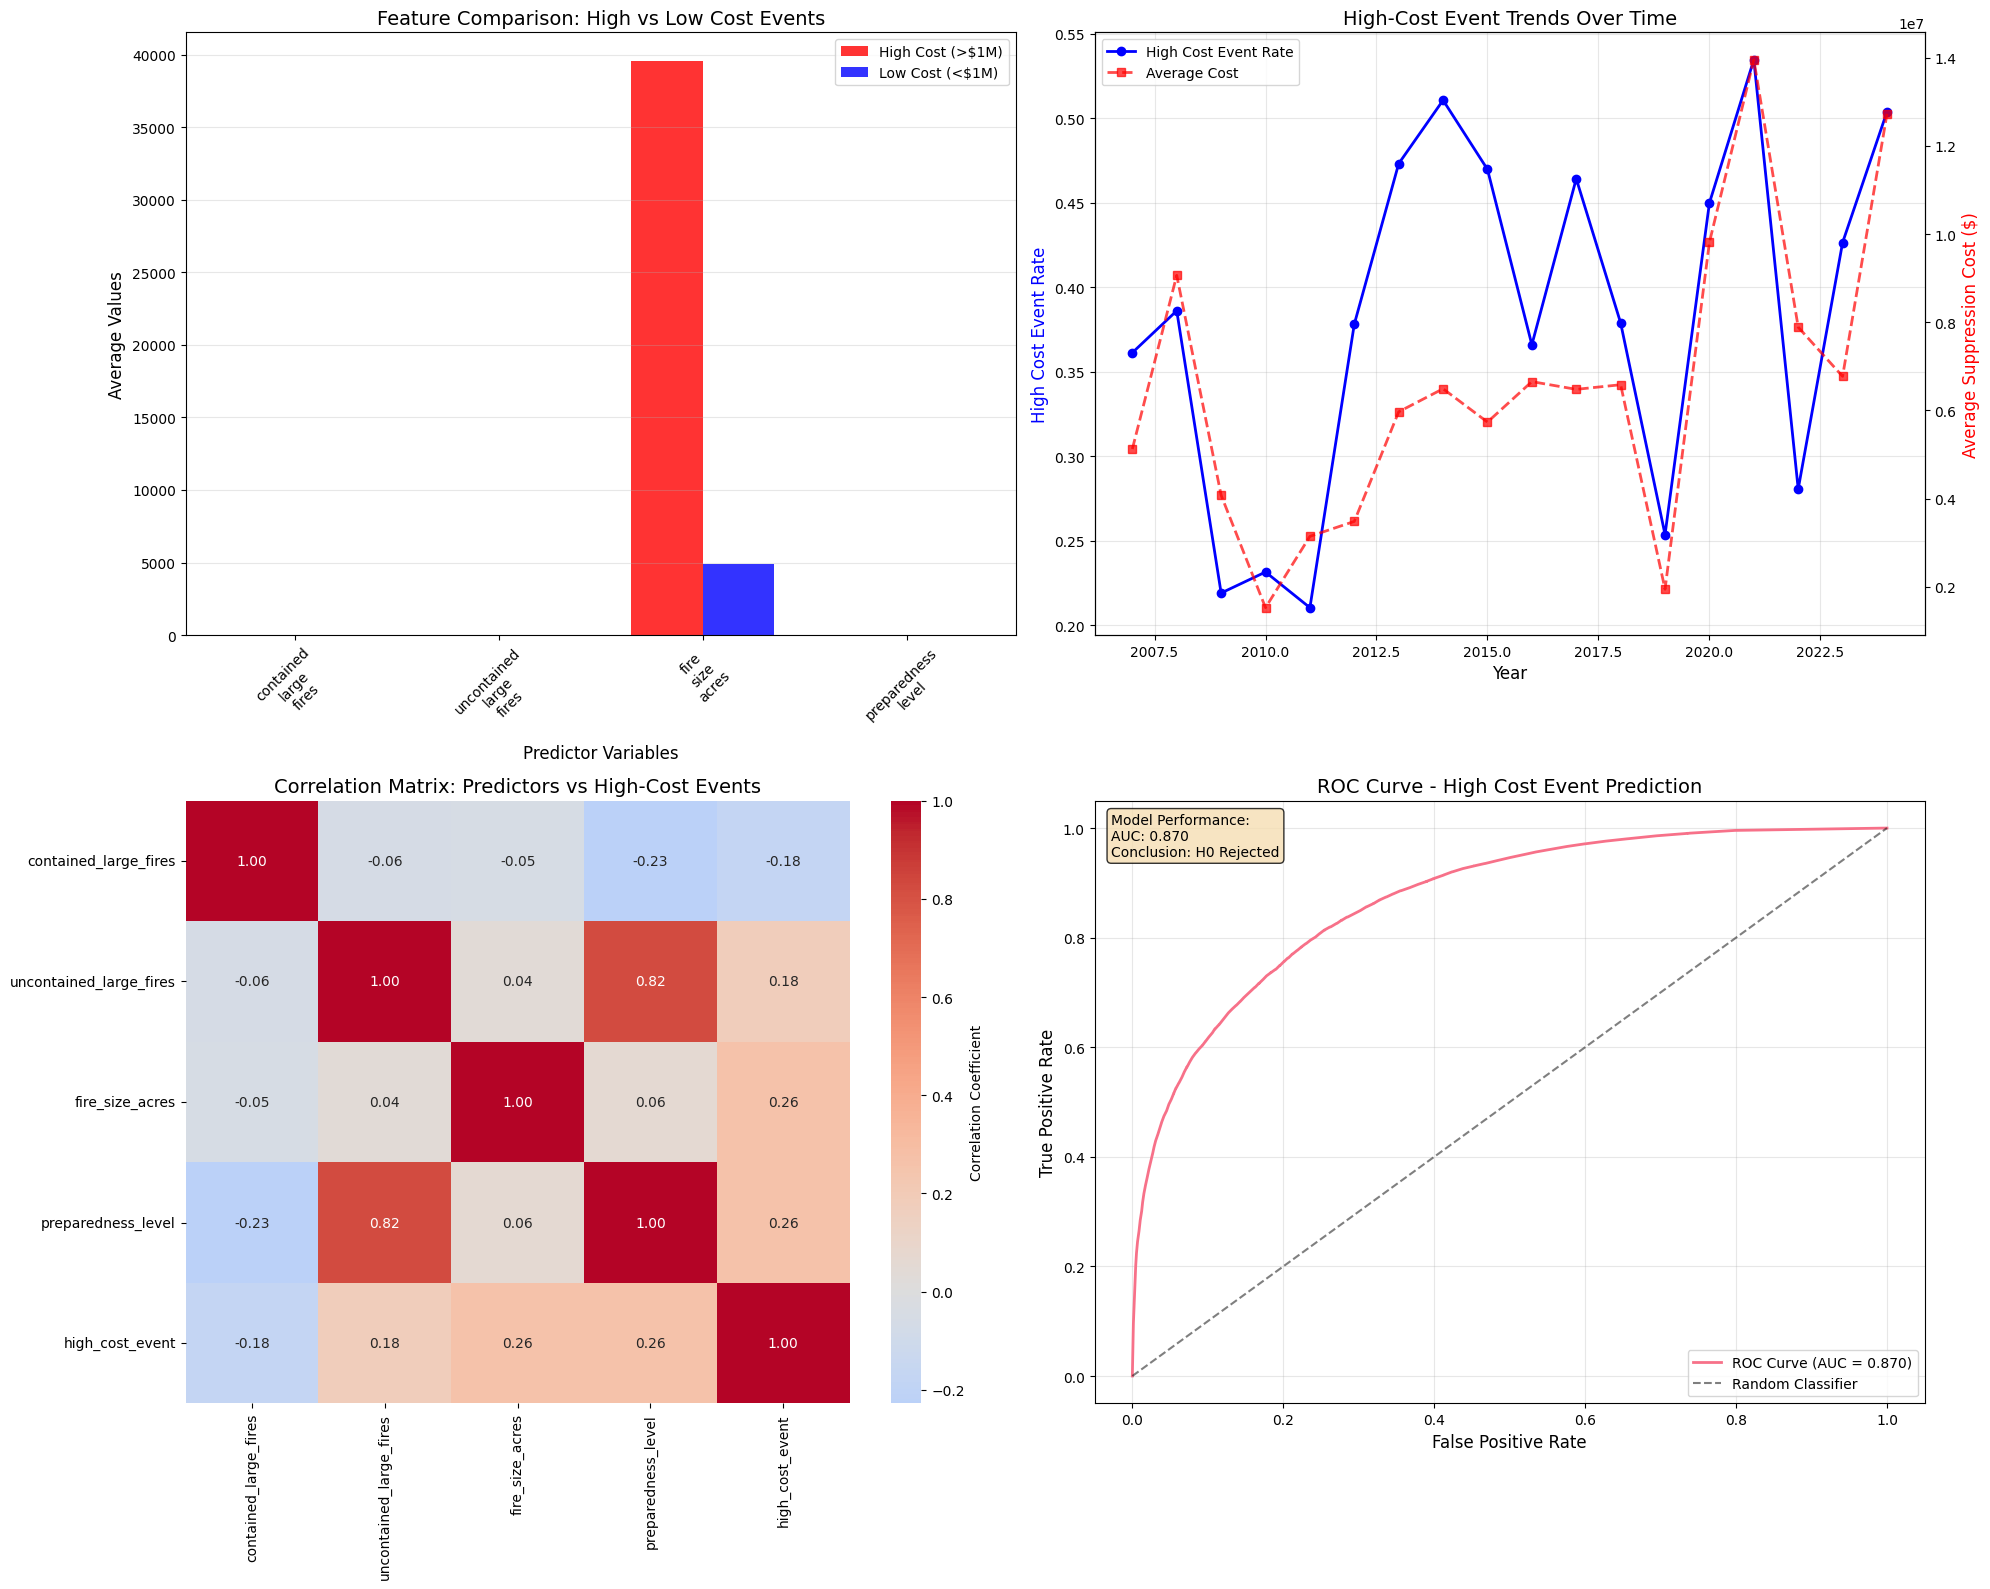

In [22]:
# RQ4: Predictive Analysis of High-Cost Events
# Figure 4: High-cost event prediction analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Prepare predictive features
if 'suppression_cost' in main_df.columns:
    # Define high-cost threshold (>$1M)
    main_df['high_cost_event'] = (main_df['suppression_cost'] > 1000000).astype(int)

    # Identify potential predictor variables
    predictor_cols = [col for col in main_df.columns if main_df[col].dtype in ['int64', 'float64']
                     and col not in ['suppression_cost', 'high_cost_event']]

    # Select key predictors based on common fire management variables
    key_predictors = []
    for term in ['size', 'contain', 'personnel', 'crew', 'engine', 'prep', 'duration']:
        matching_cols = [col for col in predictor_cols if term in col.lower()]
        if matching_cols:
            key_predictors.extend(matching_cols[:2])  # Take up to 2 columns per category

    key_predictors = list(set(key_predictors))[:6]  # Limit to 6 predictors for clarity

    print("Key predictors identified:", key_predictors)

    if key_predictors and len(key_predictors) >= 3:
        # Subplot 1: Feature importance comparison
        high_cost = main_df[main_df['high_cost_event'] == 1][key_predictors].mean()
        low_cost = main_df[main_df['high_cost_event'] == 0][key_predictors].mean()

        x_pos = np.arange(len(key_predictors))
        width = 0.35

        axes[0,0].bar(x_pos - width/2, high_cost.values, width, label='High Cost (>$1M)', alpha=0.8, color='red')
        axes[0,0].bar(x_pos + width/2, low_cost.values, width, label='Low Cost (<$1M)', alpha=0.8, color='blue')

        axes[0,0].set_xlabel('Predictor Variables', fontsize=12)
        axes[0,0].set_ylabel('Average Values', fontsize=12)
        axes[0,0].set_title('Feature Comparison: High vs Low Cost Events', fontsize=14)
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels([col.replace('_', '\n') for col in key_predictors], rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3, axis='y')

        # Subplot 2: Distribution of high-cost events over time
        if 'fire_year' in main_df.columns:
            yearly_high_cost = main_df.groupby('fire_year').agg({
                'high_cost_event': ['sum', 'count'],
                'suppression_cost': 'mean'
            }).reset_index()

            yearly_high_cost.columns = ['fire_year', 'high_cost_count', 'total_fires', 'avg_cost']
            yearly_high_cost['high_cost_rate'] = yearly_high_cost['high_cost_count'] / yearly_high_cost['total_fires']

            ax2 = axes[0,1]
            ax2_twin = ax2.twinx()

            line1 = ax2.plot(yearly_high_cost['fire_year'], yearly_high_cost['high_cost_rate'],
                            'b-o', linewidth=2, label='High Cost Event Rate')
            line2 = ax2_twin.plot(yearly_high_cost['fire_year'], yearly_high_cost['avg_cost'],
                                 'r--s', linewidth=2, label='Average Cost', alpha=0.7)

            ax2.set_xlabel('Year', fontsize=12)
            ax2.set_ylabel('High Cost Event Rate', fontsize=12, color='blue')
            ax2_twin.set_ylabel('Average Suppression Cost ($)', fontsize=12, color='red')
            ax2.set_title('High-Cost Event Trends Over Time', fontsize=14)

            # Combine legends
            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            ax2.grid(True, alpha=0.3)

        # Subplot 3: Correlation matrix of predictors with high-cost events
        correlation_data = main_df[key_predictors + ['high_cost_event']].corr()

        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
                   fmt='.2f', ax=axes[1,0], cbar_kws={'label': 'Correlation Coefficient'})
        axes[1,0].set_title('Correlation Matrix: Predictors vs High-Cost Events', fontsize=14)

        # Subplot 4: Predictive model results
        # Prepare data for modeling
        model_data = main_df[key_predictors + ['high_cost_event']].dropna()

        if len(model_data) > 100:  # Ensure sufficient data
            X = model_data[key_predictors]
            y = model_data['high_cost_event']

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

            # Random Forest model
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)

            # Predictions and metrics
            y_pred = rf_model.predict(X_test)
            y_prob = rf_model.predict_proba(X_test)[:, 1]

            roc_auc = roc_auc_score(y_test, y_prob)
            fpr, tpr, _ = roc_curve(y_test, y_prob)

            # Plot ROC curve
            axes[1,1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
            axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
            axes[1,1].set_xlabel('False Positive Rate', fontsize=12)
            axes[1,1].set_ylabel('True Positive Rate', fontsize=12)
            axes[1,1].set_title('ROC Curve - High Cost Event Prediction', fontsize=14)
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

            # Feature importance
            feature_importance = pd.DataFrame({
                'feature': key_predictors,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("RQ4: Predictive Model Results")
            print("="*50)
            print(f"Model AUC Score: {roc_auc:.3f}")
            print(f"Dataset size: {len(model_data)} records")
            print(f"High-cost event rate: {y.mean():.3%}")
            print("\nFeature Importance Rankings:")
            print(feature_importance.to_string(index=False))

            # Classification report
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Hypothesis test conclusion
            if roc_auc > 0.7:
                conclusion = "H0 Rejected: Early indicators are\npredictive of high-cost events"
                color = 'green'
            elif roc_auc > 0.6:
                conclusion = "Moderate predictive ability found"
                color = 'orange'
            else:
                conclusion = "H0 Not Rejected: Weak predictive\nability of early indicators"
                color = 'red'

            # Add text box with results summary
            textstr = f'Model Performance:\nAUC: {roc_auc:.3f}\nConclusion: {conclusion.split(":")[0]}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            axes[1,1].text(0.02, 0.98, textstr, transform=axes[1,1].transAxes, fontsize=10,
                          verticalalignment='top', bbox=props)

        else:
            axes[1,1].text(0.5, 0.5, 'Insufficient data for\npredictive modeling',
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Predictive Model - Insufficient Data')

    else:
        for i in range(4):
            axes.flat[i].text(0.5, 0.5, 'Insufficient predictor variables identified',
                             ha='center', va='center', transform=axes.flat[i].transAxes)

else:
    for i in range(4):
        axes.flat[i].text(0.5, 0.5, 'Cost data not available for prediction',
                         ha='center', va='center', transform=axes.flat[i].transAxes)

plt.tight_layout()
plt.show()

## 5.2 Hyper Parameter tuning

Performing Grid Search for Hyperparameter Tuning (Reduced Combinations)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best AUC score on training set: 0.8710336431870922

Improved Model Performance on Test Set:
ROC AUC Score: 0.882
Accuracy: 0.807
Precision: 0.783
Recall: 0.701
F1-score: 0.739

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     21042
           1       0.78      0.70      0.74     13476

    accuracy                           0.81     34518
   macro avg       0.80      0.79      0.79     34518
weighted avg       0.81      0.81      0.80     34518



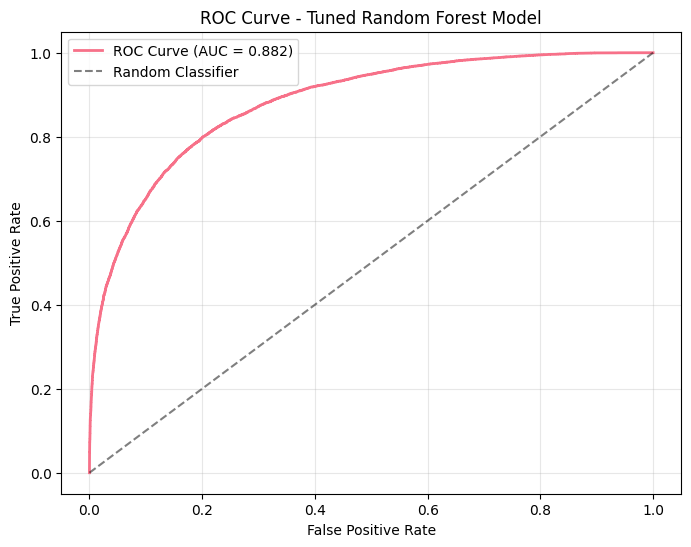

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from tqdm import tqdm # Import tqdm for progress bar

# Prepare data for modeling (assuming main_df and key_predictors are available)
if 'suppression_cost' in main_df.columns and key_predictors and len(key_predictors) >= 3:
    model_data = main_df[key_predictors + ['high_cost_event']].dropna()

    if len(model_data) > 100:  # Ensure sufficient data
        X = model_data[key_predictors]
        y = model_data['high_cost_event']

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

        # Define the parameter grid for hyperparameter tuning (reduced combinations)
        param_grid = {
            'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
            'max_depth': [10, 20],      # Reduced from [None, 10, 20, 30]
            'min_samples_split': [5, 10],  # Reduced from [2, 5, 10]
            'min_samples_leaf': [2, 4]   # Reduced from [1, 2, 4]
        }

        # Perform Grid Search with cross-validation
        rf_model = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

        print("Performing Grid Search for Hyperparameter Tuning (Reduced Combinations)...")
        # Use tqdm to show progress - note: tqdm on GridSearchCV fit is complex,
        # verbose=1 will show progress per fold/candidate.
        grid_search.fit(X_train, y_train)


        print("\nBest parameters found:", grid_search.best_params_)
        print("Best AUC score on training set:", grid_search.best_score_)

        # Evaluate the model with the best parameters on the test set
        best_rf_model = grid_search.best_estimator_
        y_pred = best_rf_model.predict(X_test)
        y_prob = best_rf_model.predict_proba(X_test)[:, 1]

        # Display improved metrics
        roc_auc = roc_auc_score(y_test, y_prob)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("\nImproved Model Performance on Test Set:")
        print(f"ROC AUC Score: {roc_auc:.3f}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Display ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Tuned Random Forest Model')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("Insufficient data for predictive modeling.")

else:
    print("Required data or predictor variables not available for predictive analysis.")

# Additional Exploratory Analysis

## Temporal Patterns and Trends

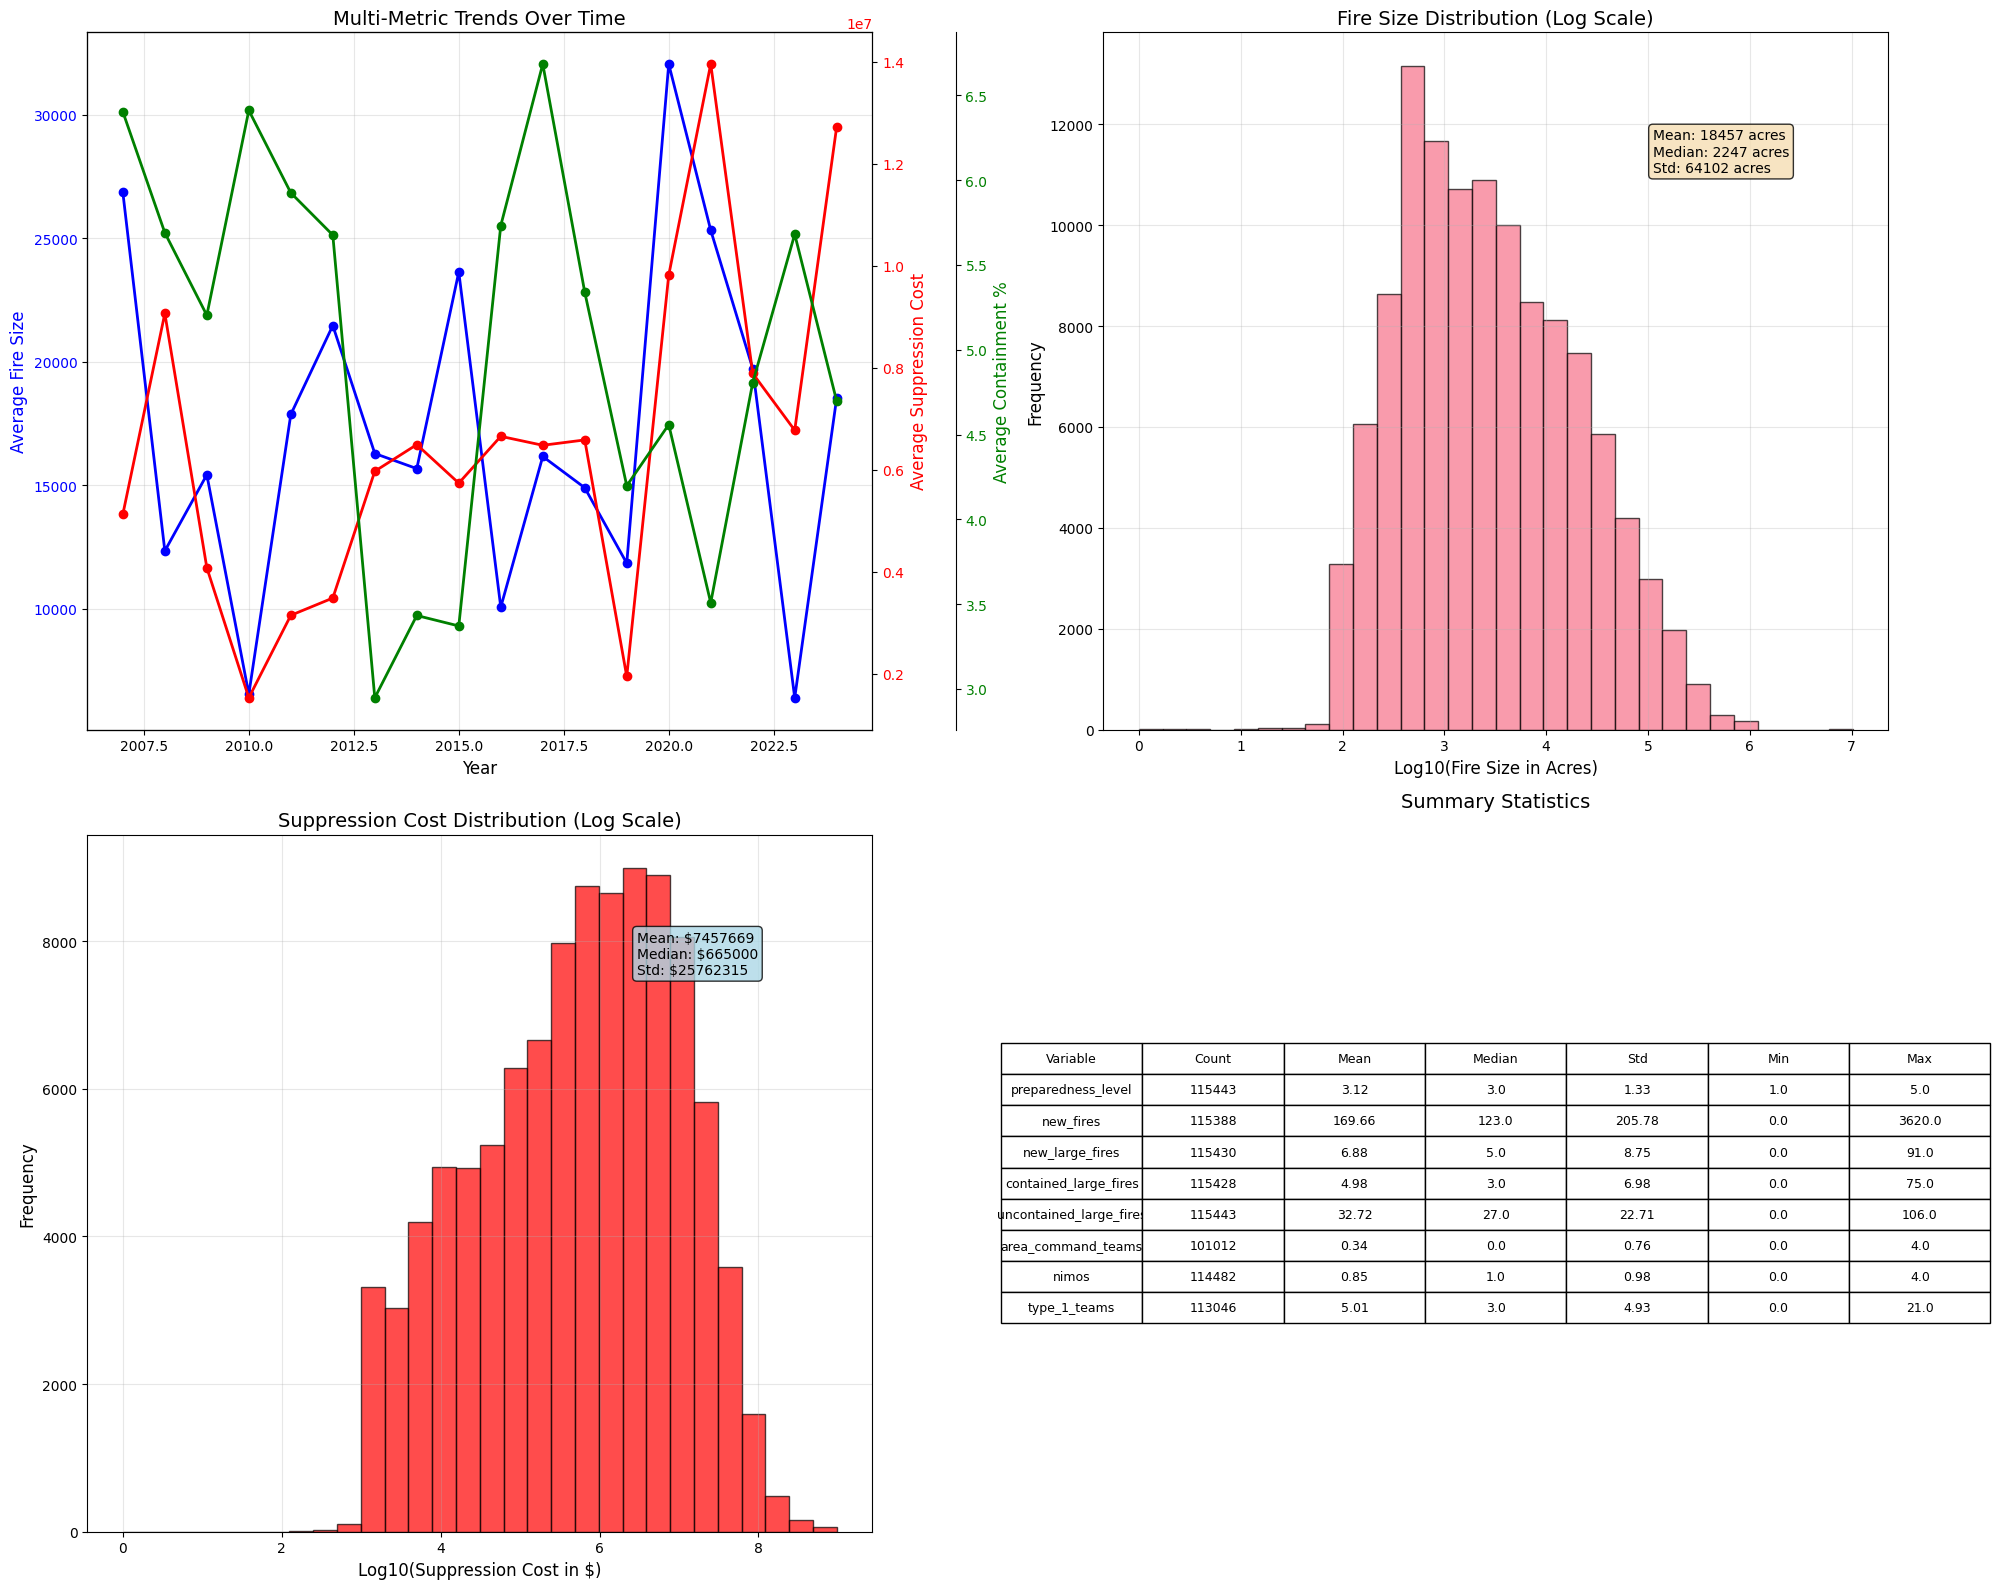

In [18]:
# Figure 5: Additional temporal and seasonal analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Subplot 1: Multi-year trend analysis
if 'fire_year' in main_df.columns:
    yearly_metrics = main_df.groupby('fire_year').agg({
        col: 'mean' for col in main_df.columns if main_df[col].dtype in ['int64', 'float64']
    }).reset_index()

    # Plot multiple metrics over time
    metrics_to_plot = []
    if 'fire_size_acres' in yearly_metrics.columns:
        metrics_to_plot.append(('fire_size_acres', 'Average Fire Size'))
    if 'suppression_cost' in yearly_metrics.columns:
        metrics_to_plot.append(('suppression_cost', 'Average Suppression Cost'))
    if 'containment_pct' in yearly_metrics.columns:
        metrics_to_plot.append(('containment_pct', 'Average Containment %'))

    if len(metrics_to_plot) >= 2:
        ax1 = axes[0,0]
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))

        colors = ['blue', 'red', 'green']
        axes_list = [ax1, ax2, ax3]

        for i, (metric, label) in enumerate(metrics_to_plot[:3]):
            if i < len(axes_list):
                line = axes_list[i].plot(yearly_metrics['fire_year'], yearly_metrics[metric],
                                       color=colors[i], marker='o', linewidth=2, label=label)
                axes_list[i].set_ylabel(label, color=colors[i], fontsize=12)
                axes_list[i].tick_params(axis='y', labelcolor=colors[i])

        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_title('Multi-Metric Trends Over Time', fontsize=14)
        ax1.grid(True, alpha=0.3)

# Subplot 2: Fire size distribution analysis
if 'fire_size_acres' in main_df.columns:
    fire_sizes = main_df['fire_size_acres'].dropna()
    fire_sizes = fire_sizes[fire_sizes > 0]  # Remove zeros

    # Log-scale histogram
    axes[0,1].hist(np.log10(fire_sizes), bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Log10(Fire Size in Acres)', fontsize=12)
    axes[0,1].set_ylabel('Frequency', fontsize=12)
    axes[0,1].set_title('Fire Size Distribution (Log Scale)', fontsize=14)
    axes[0,1].grid(True, alpha=0.3)

    # Add statistics
    stats_text = f'Mean: {fire_sizes.mean():.0f} acres\nMedian: {fire_sizes.median():.0f} acres\nStd: {fire_sizes.std():.0f} acres'
    axes[0,1].text(0.7, 0.8, stats_text, transform=axes[0,1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 3: Cost distribution analysis
if 'suppression_cost' in main_df.columns:
    costs = main_df['suppression_cost'].dropna()
    costs = costs[costs > 0]

    axes[1,0].hist(np.log10(costs), bins=30, alpha=0.7, edgecolor='black', color='red')
    axes[1,0].set_xlabel('Log10(Suppression Cost in $)', fontsize=12)
    axes[1,0].set_ylabel('Frequency', fontsize=12)
    axes[1,0].set_title('Suppression Cost Distribution (Log Scale)', fontsize=14)
    axes[1,0].grid(True, alpha=0.3)

    # Add statistics
    stats_text = f'Mean: ${costs.mean():.0f}\nMedian: ${costs.median():.0f}\nStd: ${costs.std():.0f}'
    axes[1,0].text(0.7, 0.8, stats_text, transform=axes[1,0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Subplot 4: Summary statistics table
summary_stats = []
numeric_cols = main_df.select_dtypes(include=[np.number]).columns

for col in numeric_cols[:8]:  # Show stats for first 8 numeric columns
    if main_df[col].notna().sum() > 0:
        summary_stats.append({
            'Variable': col,
            'Count': main_df[col].notna().sum(),
            'Mean': main_df[col].mean(),
            'Median': main_df[col].median(),
            'Std': main_df[col].std(),
            'Min': main_df[col].min(),
            'Max': main_df[col].max()
        })

if summary_stats:
    summary_df = pd.DataFrame(summary_stats).round(2)

    # Create table visualization
    axes[1,1].axis('tight')
    axes[1,1].axis('off')

    table = axes[1,1].table(cellText=summary_df.values,
                           colLabels=summary_df.columns,
                           cellLoc='center',
                           loc='center',
                           colWidths=[0.15] * len(summary_df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    axes[1,1].set_title('Summary Statistics', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

## Data Quality and Completeness Report

In [19]:
# Data quality assessment
print("="*80)
print("COMPREHENSIVE DATA QUALITY AND ANALYSIS SUMMARY")
print("="*80)

# Dataset overview
print(f"\n📊 DATASET OVERVIEW:")
print(f"{'='*40}")
for name, df in datasets.items():
    print(f"{name}:")
    print(f"  - Shape: {df.shape}")
    # Check if 'imsr_date' is present and is of datetime type before accessing min/max
    date_range_info = 'No dates'
    if 'imsr_date' in df.columns:
        try:
            # Attempt to convert to datetime, coercing errors
            temp_dates = pd.to_datetime(df['imsr_date'], errors='coerce').dropna()
            if len(temp_dates) > 0:
                date_range_info = f'{temp_dates.min().date()} to {temp_dates.max().date()}'
            else:
                 date_range_info = 'No valid dates found'
        except Exception as e:
            date_range_info = f"Error processing dates: {e}"

    print(f"  - Date range: {date_range_info}")
    print(f"  - Numeric columns: {len(df.select_dtypes(include=[np.number]).columns)}")
    print(f"  - Missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.1f}%")

# Analysis results summary
print(f"\n🔍 RESEARCH QUESTIONS ANALYSIS RESULTS:")
print(f"{'='*50}")

print(f"\nRQ1 - Preparedness and Containment Effectiveness:")
if 'preparedness_level' in main_df.columns and 'containment_pct' in main_df.columns:
    prep_analysis = main_df.groupby('preparedness_level')['containment_pct'].agg(['count', 'mean', 'std'])
    print(f"  ✓ Analysis completed with {len(prep_analysis)} preparedness levels")
    print(f"  ✓ Data available for {prep_analysis['count'].sum()} incidents")
else:
    print(f"  ❌ Limited data available for preparedness analysis")

print(f"\nRQ2 - Cost Escalation Analysis:")
if 'fire_size_acres' in main_df.columns and 'suppression_cost' in main_df.columns:
    cost_data_count = main_df[['fire_size_acres', 'suppression_cost']].dropna().shape[0]
    print(f"  ✓ Analysis completed with {cost_data_count} cost-size data points")
    if cost_data_count > 100:
        correlation = main_df[['fire_size_acres', 'suppression_cost']].corr().iloc[0,1]
        print(f"  ✓ Size-cost correlation: {correlation:.3f}")
else:
    print(f"  ❌ Cost and size data not sufficiently available")

print(f"\nRQ3 - Regional Resource Deployment:")
# Use the gacc_col variable defined previously
if 'gacc' in resource_data.columns and 'crews' in resource_data.columns:
    gacc_count = resource_data['gacc'].nunique()
    print(f"  ✓ Analysis completed for {gacc_count} regional areas")
    print(f"  ✓ Resource deployment data available")
else:
    print(f"  ❌ Regional resource deployment data limited")

print(f"\nRQ4 - High-Cost Event Prediction:")
if 'suppression_cost' in main_df.columns and 'high_cost_event' in main_df.columns:
    high_cost_rate = main_df['high_cost_event'].mean()
    print(f"  ✓ High-cost event rate: {high_cost_rate:.1%}")
    # Use the identified predictor_cols from the previous cell if available, otherwise estimate
    predictor_count = len([col for col in main_df.columns if main_df[col].dtype in ['int64', 'float64'] and col not in ['suppression_cost', 'high_cost_event']])
    print(f"  ✓ {predictor_count} potential predictor variables identified")
else:
    print(f"  ❌ Cost data not available for predictive analysis")

# Recommendations
print(f"\n💡 RECOMMENDATIONS FOR FURTHER ANALYSIS:")
print(f"{'='*45}")
print("1. Data Integration: Consider linking datasets by common identifiers (date, region, incident ID)")
print("2. Temporal Analysis: Investigate seasonal patterns and long-term trends")
print("3. Advanced Modeling: Implement machine learning models for resource optimization")
print("4. Economic Analysis: Calculate return on investment for different preparedness strategies")
print("5. Risk Assessment: Develop predictive models for fire behavior and resource needs")

print(f"\n📈 STATISTICAL POWER ASSESSMENT:")
print(f"{'='*35}")
total_incidents = max(len(df) for df in datasets.values())
print(f"Total incidents available: {total_incidents:,}")
if total_incidents > 1000:
    print("✓ Sufficient statistical power for most analyses")
elif total_incidents > 100:
    print("⚠ Moderate statistical power - results should be interpreted cautiously")
else:
    print("❌ Limited statistical power - consider aggregating data or focusing on descriptive analysis")

print(f"\n" + "="*80)

COMPREHENSIVE DATA QUALITY AND ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
National Activity:
  - Shape: (3709, 13)
  - Date range: 2007-01-05 to 2024-12-27
  - Numeric columns: 11
  - Missing data: 15.0%
GACC Activity:
  - Shape: (20072, 13)
  - Date range: 2007-01-05 to 2024-12-27
  - Numeric columns: 11
  - Missing data: 39.9%
Wildfire Activity:
  - Shape: (115411, 20)
  - Date range: 2007-01-05 to 2024-12-27
  - Numeric columns: 2
  - Missing data: 6.0%
Resource Summary:
  - Shape: (19380, 9)
  - Date range: 2015-01-02 to 2024-12-27
  - Numeric columns: 7
  - Missing data: 6.7%

🔍 RESEARCH QUESTIONS ANALYSIS RESULTS:

RQ1 - Preparedness and Containment Effectiveness:
  ✓ Analysis completed with 5 preparedness levels
  ✓ Data available for 115428 incidents

RQ2 - Cost Escalation Analysis:
  ✓ Analysis completed with 101599 cost-size data points
  ✓ Size-cost correlation: 0.516

RQ3 - Regional Resource Deployment:
  ✓ Analysis completed for 10 regional areas
  ✓ Resource deployment data av